<a href="https://colab.research.google.com/github/Kennenzz/predict-employee-attrition/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**XÂY DỰNG MÔ HÌNH DỰ ĐOÁN NGUY CƠ NGHỈ VIỆC CỦA NHÂN VIÊN**
---

**#Import các thư viện sẽ sử dụng trong đồ án bao gồm:**
*   **Pandas**
*   **Numpy**
*   **Matplotlib**
*   **Seaborn**
*   **Matplotlib**
*   **Imblearn**
*   **Sklearn**
*   **LightGBM**
*   **XGBoost**
*   **Pytorch Tabnet**

In [1]:
import pandas as pd
import joblib
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from pytorch_tabnet.tab_model import TabNetClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

---
**Đọc file dataset**

In [2]:
try:
    df = pd.read_csv("Dataset.csv")
    display(df.head())
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file dataset trong dữ liệu folder")
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

---
**Mô tả tổng quan về dataset**

In [3]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

None

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335                 1.093082    20.329428        0.711561   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.250000                 2.000000    48.000000        2.000000   
50%       1020.500000                 3.000000    66.000000        3.000000   
75%       1555.750000                 4.000000    83.750000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  ...  RelationshipSatisfaction  StandardHours  \
count  1470.000000  ...               1470.000000         1470.0   
mean      2.063946  ...                  2.712245           80.0   
std       1.106940  ...                  1.081209            0.0   
min       1.000000  ...                  1.000000           80.0   
25%       1.000000  ...                  2.000000           80.0   
50%       2.000000  ...                  3.000000           80.0   
75%       3.000000  ...                  4.000000           80.0   
max       5.000000  ...                  4.000000           80.0   

       StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
count       1470.000000        1470.000000            1470.000000   
mean           0.793878          11.279592               2.799320   
std            0.852077           7.780782               1.289271   
min            0.000000           0.000000               0.000000   
25%            0.000000           6.000000               2.000000   
50%            1.000000          10.000000               3.000000   
75%            1.000000          15.000000               3.000000   
max            3.000000          40.000000               6.000000   

       WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
count      1470.000000     1470.000000         1470.000000   
mean          2.761224        7.008163            4.229252   
std           0.706476        6.126525            3.623137   
min           1.000000        0.000000            0.000000   
25%           2.000000        3.000000            2.000000   
50%           3.000000        5.000000            3.000000   
75%           3.000000        9.000000            7.000000   
max           4.000000       40.000000           18.000000   

       YearsSinceLastPromotion  YearsWithCurrManager  
count              1470.000000           1470.000000  
mean                  2.187755              4.123129  
std                   3.222430              3.568136  
min                   0.000000              0.000000  
25%                   0.000000              2.000000  
50%                   1.000000              3.000000  
75%                   3.000000              7.000000  
max                  15.000000             17.000000  

[8 rows x 26 columns]

(1470, 35)

**Tổng quan: Dataset thông tin của nhân viên gồm có 1470 mẫu và 35 cột (thuộc tinh)**


---
# Phân loại các biến trong dataset

In [4]:
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

print("Biến số:")
display(numerical_cols)

print("\nBiến phân loại:")
display(categorical_cols)

Biến số:


Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


Biến phân loại:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

---
**Tiền xử lý dữ liệu**

In [5]:
# Xử lý chuẩn hóa dữ liệu
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển đổi sang kiểu số, lỗi sẽ thành NaN
    if df[col].isnull().any():
        print(f"Cảnh báo: Cột '{col}' có giá trị không thể chuyển đổi sang số.")
    print(f"Cột '{col}' đã được chuyển đổi sang kiểu số.")


for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}': {unique_values}")
    df[col] = df[col].str.strip().str.lower()   # Loại bỏ khoảng trắng và chuyển về chữ thường  
    unique_values_after = df[col].unique()
    print(f"Giá trị duy nhất trong cột '{col}' sau khi xử lý: {unique_values_after}")

Cột 'Age' đã được chuyển đổi sang kiểu số.
Cột 'DailyRate' đã được chuyển đổi sang kiểu số.
Cột 'DistanceFromHome' đã được chuyển đổi sang kiểu số.
Cột 'Education' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeCount' đã được chuyển đổi sang kiểu số.
Cột 'EmployeeNumber' đã được chuyển đổi sang kiểu số.
Cột 'EnvironmentSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'HourlyRate' đã được chuyển đổi sang kiểu số.
Cột 'JobInvolvement' đã được chuyển đổi sang kiểu số.
Cột 'JobLevel' đã được chuyển đổi sang kiểu số.
Cột 'JobSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyIncome' đã được chuyển đổi sang kiểu số.
Cột 'MonthlyRate' đã được chuyển đổi sang kiểu số.
Cột 'NumCompaniesWorked' đã được chuyển đổi sang kiểu số.
Cột 'PercentSalaryHike' đã được chuyển đổi sang kiểu số.
Cột 'PerformanceRating' đã được chuyển đổi sang kiểu số.
Cột 'RelationshipSatisfaction' đã được chuyển đổi sang kiểu số.
Cột 'StandardHours' đã được chuyển đổi sang kiểu số.
Cột 'StockOptionLevel' đã được ch

Xử lý dữ liệu thiếu

In [6]:
df.isnull().sum()


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

*Không có dữ liệu thiếu trong dataset*

*Xử lý dữ liệu dư thừa, dữ liệu gây nhiễu (không liên quan)*

In [7]:
df.drop(columns=['Over18', 'EmployeeNumber', 'EmployeeCount','StandardHours'], axis =1, inplace= True)
# Cập nhật lại danh sách biến phân loại sau khi loại bỏ cột
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

Qua quan sát dữ liệu thì có thể thấy các cột dữ liệu không cần thiết như sau:
*   **Over18** tất cả nhân viên đều đã trên 18 tuổi
*   **EmployeeCount** luôn có giá trị là 1
*   **EmployeeNumber** luôn có giá trị khác nhau như việc nhân viên có mã nhân viên
*   **StandardHours** luôn có giá trị là 80

In [8]:
display(df.info())
display(df.describe())
display(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

None

Age    DailyRate  DistanceFromHome    Education  \
count  1470.000000  1470.000000       1470.000000  1470.000000   
mean     36.923810   802.485714          9.192517     2.912925   
std       9.135373   403.509100          8.106864     1.024165   
min      18.000000   102.000000          1.000000     1.000000   
25%      30.000000   465.000000          2.000000     2.000000   
50%      36.000000   802.000000          7.000000     3.000000   
75%      43.000000  1157.000000         14.000000     4.000000   
max      60.000000  1499.000000         29.000000     5.000000   

       EnvironmentSatisfaction   HourlyRate  JobInvolvement     JobLevel  \
count              1470.000000  1470.000000     1470.000000  1470.000000   
mean                  2.721769    65.891156        2.729932     2.063946   
std                   1.093082    20.329428        0.711561     1.106940   
min                   1.000000    30.000000        1.000000     1.000000   
25%                   2.000000    48.000000        2.000000     1.000000   
50%                   3.000000    66.000000        3.000000     2.000000   
75%                   4.000000    83.750000        3.000000     3.000000   
max                   4.000000   100.000000        4.000000     5.000000   

       JobSatisfaction  MonthlyIncome  ...  PerformanceRating  \
count      1470.000000    1470.000000  ...        1470.000000   
mean          2.728571    6502.931293  ...           3.153741   
std           1.102846    4707.956783  ...           0.360824   
min           1.000000    1009.000000  ...           3.000000   
25%           2.000000    2911.000000  ...           3.000000   
50%           3.000000    4919.000000  ...           3.000000   
75%           4.000000    8379.000000  ...           3.000000   
max           4.000000   19999.000000  ...           4.000000   

       RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
count               1470.000000       1470.000000        1470.000000   
mean                   2.712245          0.793878          11.279592   
std                    1.081209          0.852077           7.780782   
min                    1.000000          0.000000           0.000000   
25%                    2.000000          0.000000           6.000000   
50%                    3.000000          1.000000          10.000000   
75%                    4.000000          1.000000          15.000000   
max                    4.000000          3.000000          40.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1470.000000      1470.000000     1470.000000   
mean                2.799320         2.761224        7.008163   
std                 1.289271         0.706476        6.126525   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        5.000000   
75%                 3.000000         3.000000        9.000000   
max                 6.000000         4.000000       40.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count         1470.000000              1470.000000           1470.000000  
mean             4.229252                 2.187755              4.123129  
std              3.623137                 3.222430              3.568136  
min              0.000000                 0.000000              0.000000  
25%              2.000000                 0.000000              2.000000  
50%              3.000000                 1.000000              3.000000  
75%              7.000000                 3.000000              7.000000  
max             18.000000                15.000000             17.000000  

[8 rows x 23 columns]

(1470, 31)

**Kiểu tra xem có dữ liệu trùng lặp hay không**

In [9]:

duplicate_rows = df[df.duplicated()]
print(f"Số hàng trùng lặp: {duplicate_rows.shape[0]}")
print("Các hàng trùng lặp:")
display(duplicate_rows)


Số hàng trùng lặp: 0
Các hàng trùng lặp:


Empty DataFrame
Columns: [Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager]
Index: []

[0 rows x 31 columns]

**Xử lý mã hóa biến phân loại**

In [10]:
print("Các biến phân loại sau khi loại bỏ cột không cần thiết:")
display(categorical_cols)


Các biến phân loại sau khi loại bỏ cột không cần thiết:


Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

*Mã hóa biến mục tiêu "Attrition" thành 0/1 và xử lý mã hóa các biến phân loại*

In [11]:
label_encoder = LabelEncoder()
df['Attrition'] = label_encoder.fit_transform(df['Attrition'])

def mahoabienphanloai(encoder):
    for col in categorical_cols:
        if col not in ['Attrition','Over18']:  # Bỏ qua cột đã mã hóa hoặc không cần mã hóa
            df[col] = encoder.fit_transform(df[col])
mahoabienphanloai(label_encoder)

In [12]:
display(df.info())
# hiện 100 dòng đầu tiên
display(df.head(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1470 non-null   int64
 1   Attrition                 1470 non-null   int64
 2   BusinessTravel            1470 non-null   int64
 3   DailyRate                 1470 non-null   int64
 4   Department                1470 non-null   int64
 5   DistanceFromHome          1470 non-null   int64
 6   Education                 1470 non-null   int64
 7   EducationField            1470 non-null   int64
 8   EnvironmentSatisfaction   1470 non-null   int64
 9   Gender                    1470 non-null   int64
 10  HourlyRate                1470 non-null   int64
 11  JobInvolvement            1470 non-null   int64
 12  JobLevel                  1470 non-null   int64
 13  JobRole                   1470 non-null   int64
 14  JobSatisfaction           1470 non-null 

None

Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0    41          1               2       1102           2                 1   
1    49          0               1        279           1                 8   
2    37          1               2       1373           1                 2   
3    33          0               1       1392           1                 3   
4    27          0               2        591           1                 2   
..  ...        ...             ...        ...         ...               ...   
95   54          0               2       1217           1                 2   
96   24          0               2       1353           2                 3   
97   28          0               0        120           2                 4   
98   58          0               2        682           2                10   
99   44          0               0        489           1                23   

    Education  EducationField  EnvironmentSatisfaction  Gender  ...  \
0           2               1                        2       0  ...   
1           1               1                        3       1  ...   
2           2               4                        4       1  ...   
3           4               1                        4       0  ...   
4           1               3                        1       1  ...   
..        ...             ...                      ...     ...  ...   
95          4               5                        1       0  ...   
96          2               4                        1       0  ...   
97          3               3                        2       1  ...   
98          4               3                        4       1  ...   
99          3               3                        2       1  ...   

    PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0                   3                         1                 0   
1                   4                         4                 1   
2                   3                         2                 0   
3                   3                         3                 0   
4                   3                         4                 1   
..                ...                       ...               ...   
95                  3                         1                 1   
96                  4                         1                 1   
97                  3                         2                 0   
98                  3                         3                 0   
99                  3                         3                 1   

    TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                   8                      0                1               6   
1                  10                      3                3              10   
2                   7                      3                3               0   
3                   8                      3                3               8   
4                   6                      3                3               2   
..                ...                    ...              ...             ...   
95                 16                      5                1               4   
96                  4                      2                2               3   
97                  5                      3                4               5   
98                 38                      1                2              37   
99                 17                      3                4               3   

    YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                    4                        0                     5  
1                    7                        1                     7  
2                    0                        0                     0  
3                    7                        3                     0  
4                    2                  

**Dùng IQR phát hiện các outliers và tạo ra bộ dữ liệu loại bỏ các outlier**

In [13]:
# Phát hiện ngoại lệ sử dụng IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
print("IQR values:")
print(IQR)
outlier_condition = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR)))
outlier_indices = outlier_condition.any(axis=1)
print("Chỉ số của các hàng có ngoại lệ:")
print(outlier_indices[outlier_indices].index.tolist())
print(f"\nSố lượng ngoại lệ phát hiện: {outlier_indices.sum()}")
df_cleaned_outliers = df[~outlier_indices]
print(f"Số lượng mẫu ban đầu: {df.shape[0]}")
print(f"Số lượng mẫu sau khi loại bỏ ngoại lệ: {df_cleaned_outliers.shape[0]}")

IQR values:
Age                            13.00
DailyRate                     692.00
DistanceFromHome               12.00
Education                       2.00
EnvironmentSatisfaction         2.00
HourlyRate                     35.75
JobInvolvement                  1.00
JobLevel                        2.00
JobSatisfaction                 2.00
MonthlyIncome                5468.00
MonthlyRate                 12414.50
NumCompaniesWorked              3.00
PercentSalaryHike               6.00
PerformanceRating               0.00
RelationshipSatisfaction        2.00
StockOptionLevel                1.00
TotalWorkingYears               9.00
TrainingTimesLastYear           1.00
WorkLifeBalance                 1.00
YearsAtCompany                  6.00
YearsInCurrentRole              5.00
YearsSinceLastPromotion         3.00
YearsWithCurrManager            5.00
dtype: float64
Chỉ số của các hàng có ngoại lệ:
[0, 1, 4, 6, 7, 8, 10, 15, 16, 18, 20, 21, 23, 25, 26, 28, 29, 31, 32, 33, 38, 41, 43, 44

Do việc dùng IQR để loại bỏ các ngoại lệ trong dataset gây ra sự giảm sút lớn về mặt dữ liệu mẫu (loại bỏ đến 50% mẫu) nên sẽ dùng thêm phương pháp cắt tỉa winsorizing đặt các giá trị ngoại lai về 1 ngưỡng chứ không xóa bỏ hoàn toàn giá trị ngoại lai

In [14]:
# Dùng phương pháp winsorizing để xử lý ngoại lệ
from scipy.stats.mstats import winsorize
for col in numerical_cols:
    df[col] = winsorize(df[col], limits=[0.05, 0.05])
    # Cắt tỉa 5% ở hai đầu
    # Giữ lại 90% dữ liệu ở giữa, thay thế 5% giá trị nhỏ nhất và lớn nhất bằng ngưỡng tương ứng
    print(f"Cột '{col}' đã được xử lý ngoại lệ bằng phương pháp winsorizing.")

Cột 'Age' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'DailyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'DistanceFromHome' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'Education' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'EnvironmentSatisfaction' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'HourlyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobInvolvement' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobLevel' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'JobSatisfaction' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'MonthlyIncome' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'MonthlyRate' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'NumCompaniesWorked' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'PercentSalaryHike' đã được xử lý ngoại lệ bằng phương pháp winsorizing.
Cột 'PerformanceRating' đã được xử lý ngoại lệ bằng ph

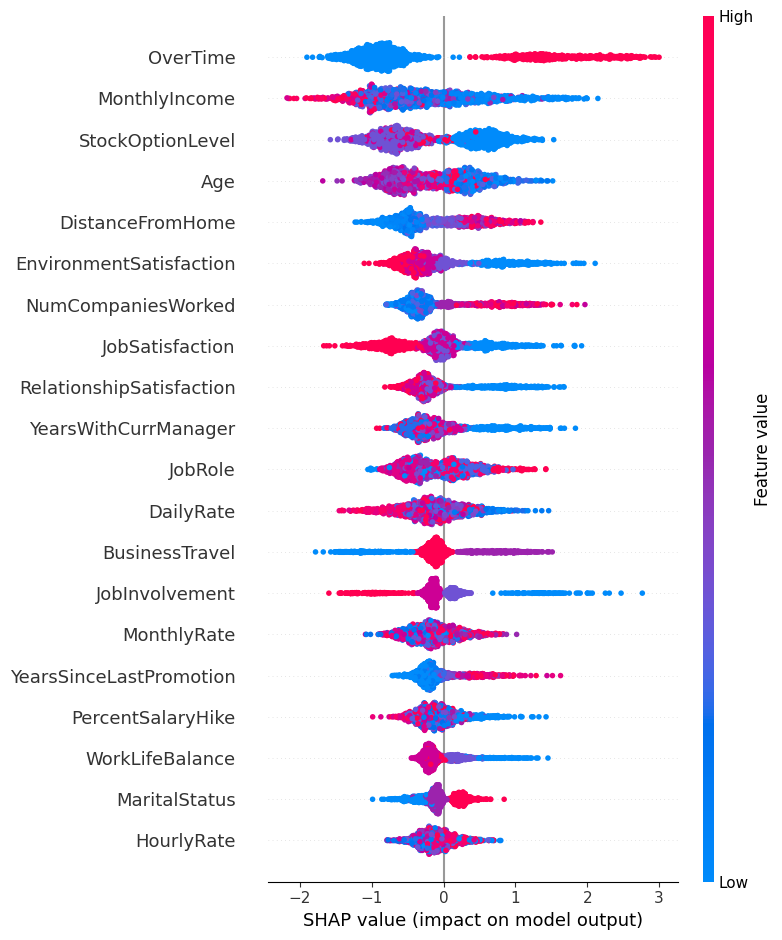

Feature  Importance
18                  OverTime    1.109685
15             MonthlyIncome    0.688121
22          StockOptionLevel    0.626588
0                        Age    0.485489
4           DistanceFromHome    0.476011
7    EnvironmentSatisfaction    0.455625
17        NumCompaniesWorked    0.446869
13           JobSatisfaction    0.431542
21  RelationshipSatisfaction    0.378072
29      YearsWithCurrManager    0.372930
12                   JobRole    0.372334
2                  DailyRate    0.358921
1             BusinessTravel    0.334335
10            JobInvolvement    0.304598
16               MonthlyRate    0.286039
28   YearsSinceLastPromotion    0.270602
19         PercentSalaryHike    0.238367
25           WorkLifeBalance    0.225203
14             MaritalStatus    0.220250
9                 HourlyRate    0.209700
23         TotalWorkingYears    0.201532
8                     Gender    0.194859
27        YearsInCurrentRole    0.190709
24     TrainingTimesLastYear    0.175991
26            YearsAtCompany    0.159611
6             EducationField    0.152403
11                  JobLevel    0.144243
3                 Department    0.093245
5                  Education    0.049250
20         PerformanceRating    0.000000

OverTime  MonthlyIncome  StockOptionLevel  Age  DistanceFromHome  \
0         1           5993                 0   41                 1   
1         0           5130                 1   49                 8   
2         1           2097                 0   37                 2   
3         1           2909                 0   33                 3   
4         0           3468                 1   27                 2   

   EnvironmentSatisfaction  NumCompaniesWorked  JobSatisfaction  \
0                        2                   8                4   
1                        3                   1                2   
2                        4                   6                3   
3                        4                   1                3   
4                        1                   8                2   

   RelationshipSatisfaction  YearsWithCurrManager  JobRole  DailyRate  \
0                         1                     5        7       1102   
1                         4                     7        6        279   
2                         2                     0        2       1373   
3                         3                     0        6       1392   
4                         4                     2        2        591   

   Attrition  
0          1  
1          0  
2          1  
3          0  
4          0

OverTime  MonthlyIncome  StockOptionLevel  Age  DistanceFromHome  \
2          1           2090                 0   37                 2   
3          1           2909                 0   33                 3   
5          0           3068                 0   32                 2   
9          0           5237                 2   36                27   
11         1           4193                 0   29                15   

    EnvironmentSatisfaction  NumCompaniesWorked  JobSatisfaction  \
2                         4                   6                3   
3                         4                   1                3   
5                         4                   0                4   
9                         3                   6                3   
11                        4                   0                3   

    RelationshipSatisfaction  YearsWithCurrManager  JobRole  DailyRate  \
2                          2                     0        2       1373   
3                          3                     0        6       1392   
5                          3                     6        2       1005   
9                          2                     7        0       1299   
11                         4                     8        2        153   

    Attrition  
2           1  
3           0  
5           0  
9           0  
11          0

In [15]:
# Phân tích và tìm ra các đặc trưng quan trọng trong bộ dữ liệu
X = df.drop('Attrition', axis=1)
y = df['Attrition']
shap_explainer = shap.TreeExplainer(XGBClassifier().fit(X, y))
shap_values = shap_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
important_features = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': important_features})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
display(feature_importance)
# lưu lại 12 đặc trưng quan trọng nhất trong bộ dữ liệu khác
top_12_features = feature_importance['Feature'].head(12).tolist()
df_top_12 = df[top_12_features + ['Attrition']]
display(df_top_12.head())
df_top_12_cleaned_outliers = df_cleaned_outliers[top_12_features + ['Attrition']]
display(df_top_12_cleaned_outliers.head())


---
#**KHAI PHÁ DỮ LIỆU EDA**


*Tổng quan về tình hình nghỉ việc của nhân viên*

Số lượng nhân viên nghỉ việc và không nghỉ việc:


Attrition
0    1233
1     237
Name: count, dtype: int64

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\3138437406.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Attrition', palette='viridis')


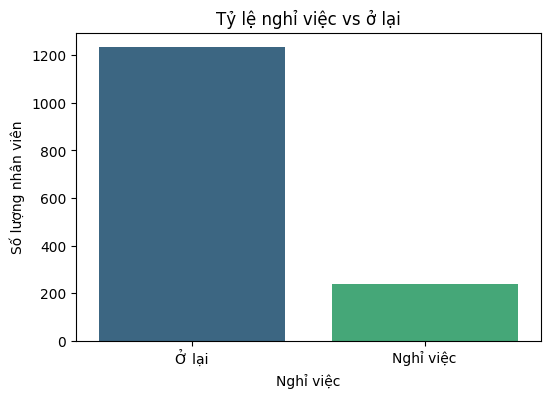


Phần trăm nhân viên nghỉ việc: 16.12%


In [16]:
# 1. Đếm số lượng nhân viên nghỉ việc và không nghỉ việc
attrition_counts = df['Attrition'].value_counts()
print("Số lượng nhân viên nghỉ việc và không nghỉ việc:")
display(attrition_counts)

# 2. Vẽ biểu đồ cột cho tỷ lệ nghỉ việc
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Attrition', palette='viridis')
plt.title('Tỷ lệ nghỉ việc vs ở lại')
plt.xticks([0, 1], ['Ở lại', 'Nghỉ việc'])
plt.xlabel('Nghỉ việc')
plt.ylabel('Số lượng nhân viên')
plt.show()

# 3. Hiển thị phần trăm nhân viên nghỉ việc
if 1 in attrition_counts.index:
	attrition_percentage = (attrition_counts[1] / len(df)) * 100
	print(f"\nPhần trăm nhân viên nghỉ việc: {attrition_percentage:.2f}%")
else:
	print("\nKhông tìm thấy giá trị '1' trong cột 'Attrition'. Kiểm tra lại dữ liệu mã hóa.")

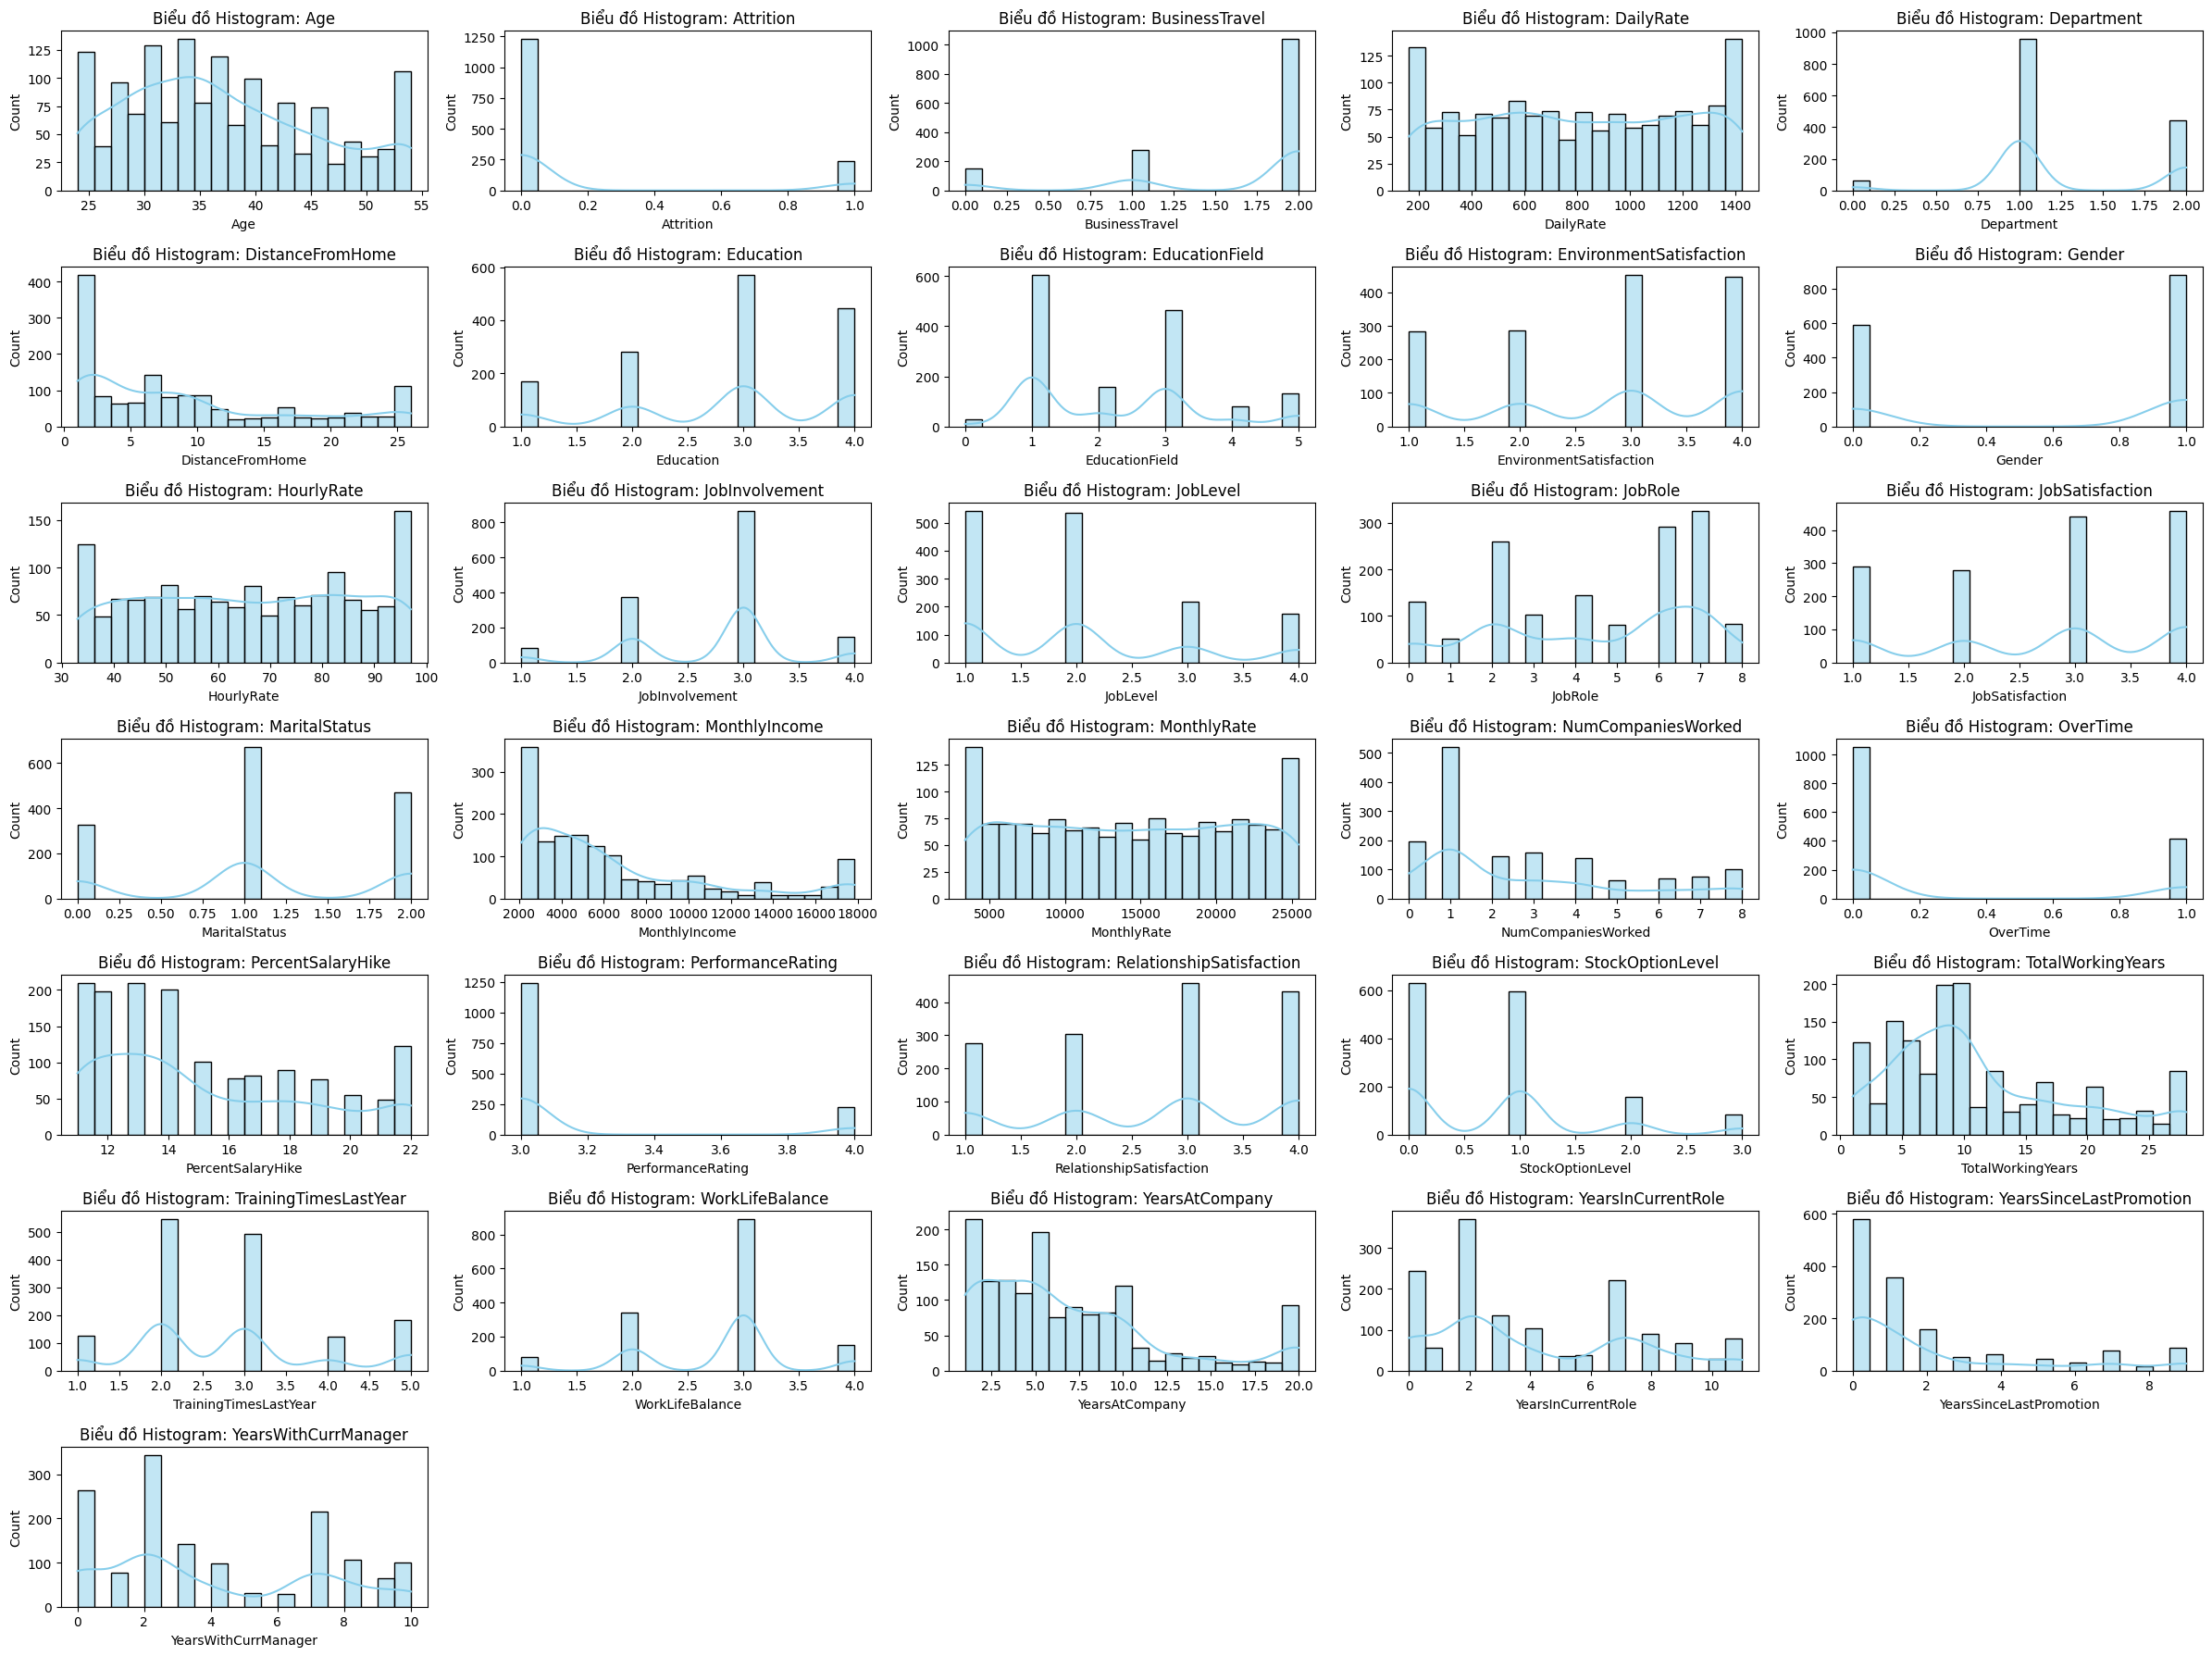

<Figure size 2400x1200 with 0 Axes>

In [17]:
# Lấy các biến số (loại trừ biến kiểu bool)
filtered_numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Tính số hàng và cột cho subplot
num_plots = len(filtered_numerical_cols)
cols = 5
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue')
    plt.title(f'Biểu đồ Histogram: {col}')
plt.tight_layout()
plt.show()

# Vẽ countplot cho các biến phân loại (chỉ vẽ cho các biến đã được mã hóa nhị phân)
plt.figure(figsize=(24, 12))
for i, col in enumerate(df.columns[df.dtypes == 'bool']):
    plt.subplot(4, 5, i + 1)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Biểu đồ Countplot: {col}')
plt.tight_layout()
plt.show()

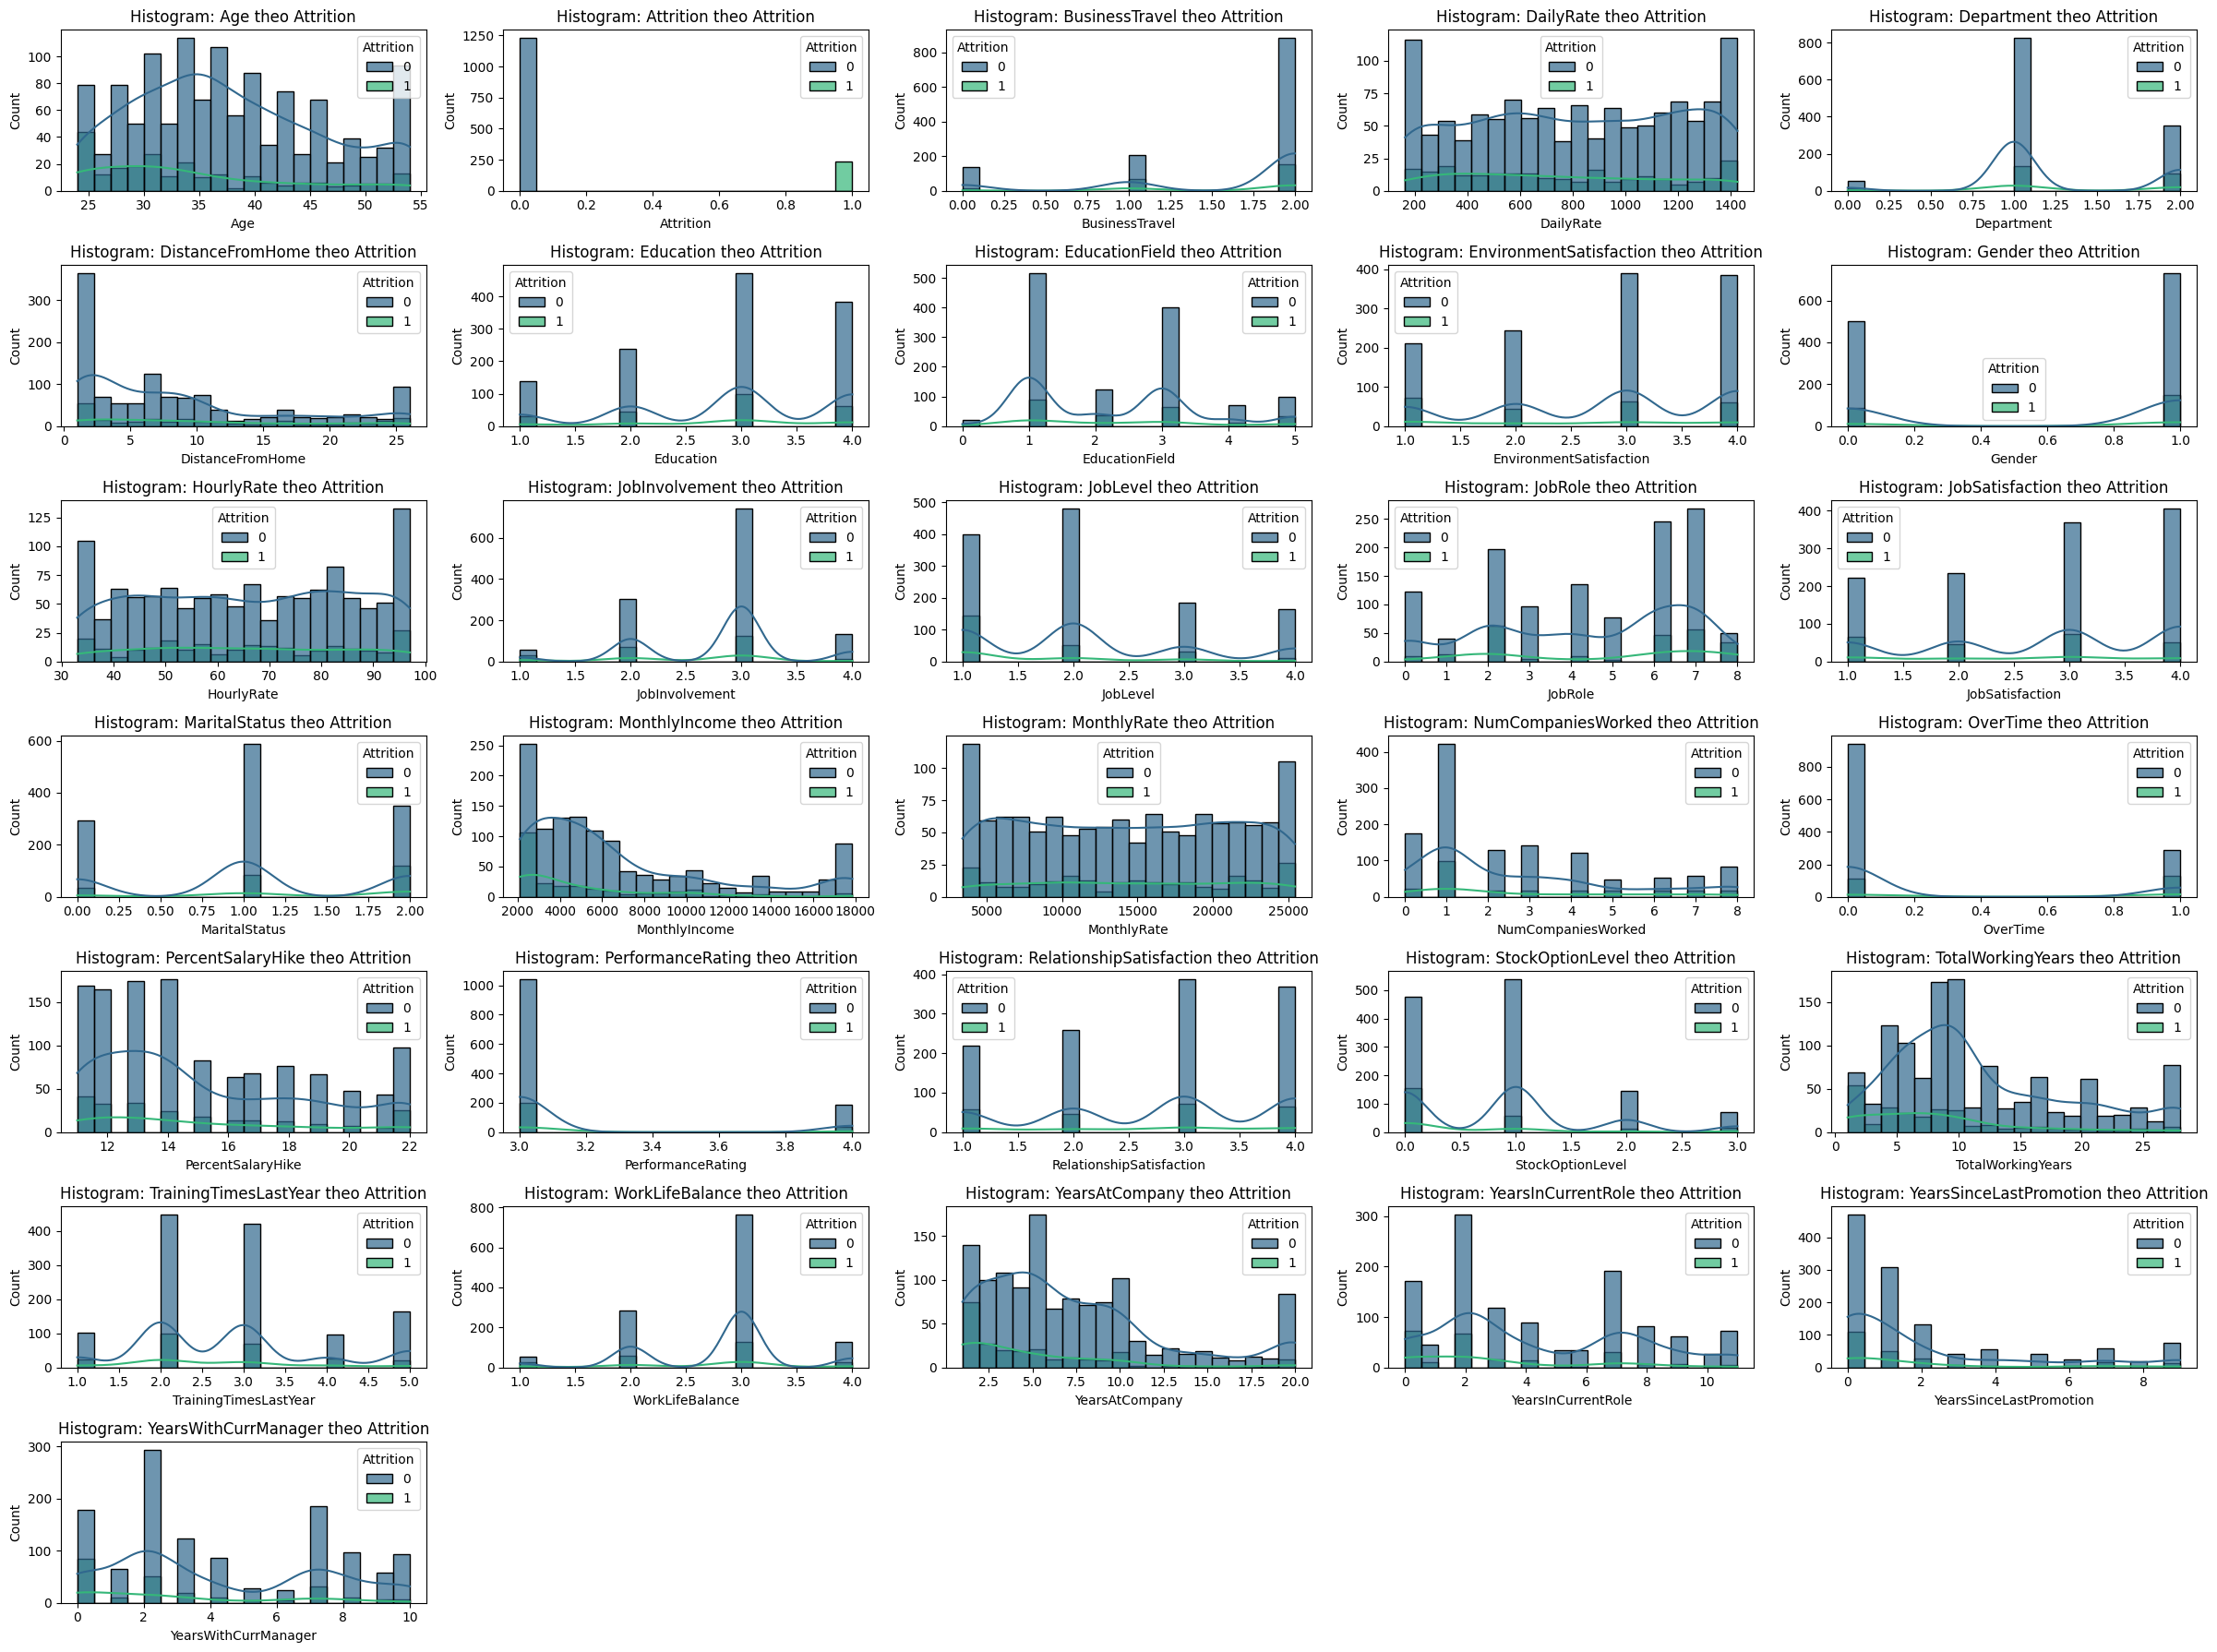

In [18]:
plt.figure(figsize=(24, 18))
for idx, col in enumerate(filtered_numerical_cols):
    plt.subplot(rows, cols, idx + 1)
    sns.histplot(data=df, x=col, hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
    plt.title(f'Histogram: {col} theo Attrition')
plt.tight_layout()
plt.show()

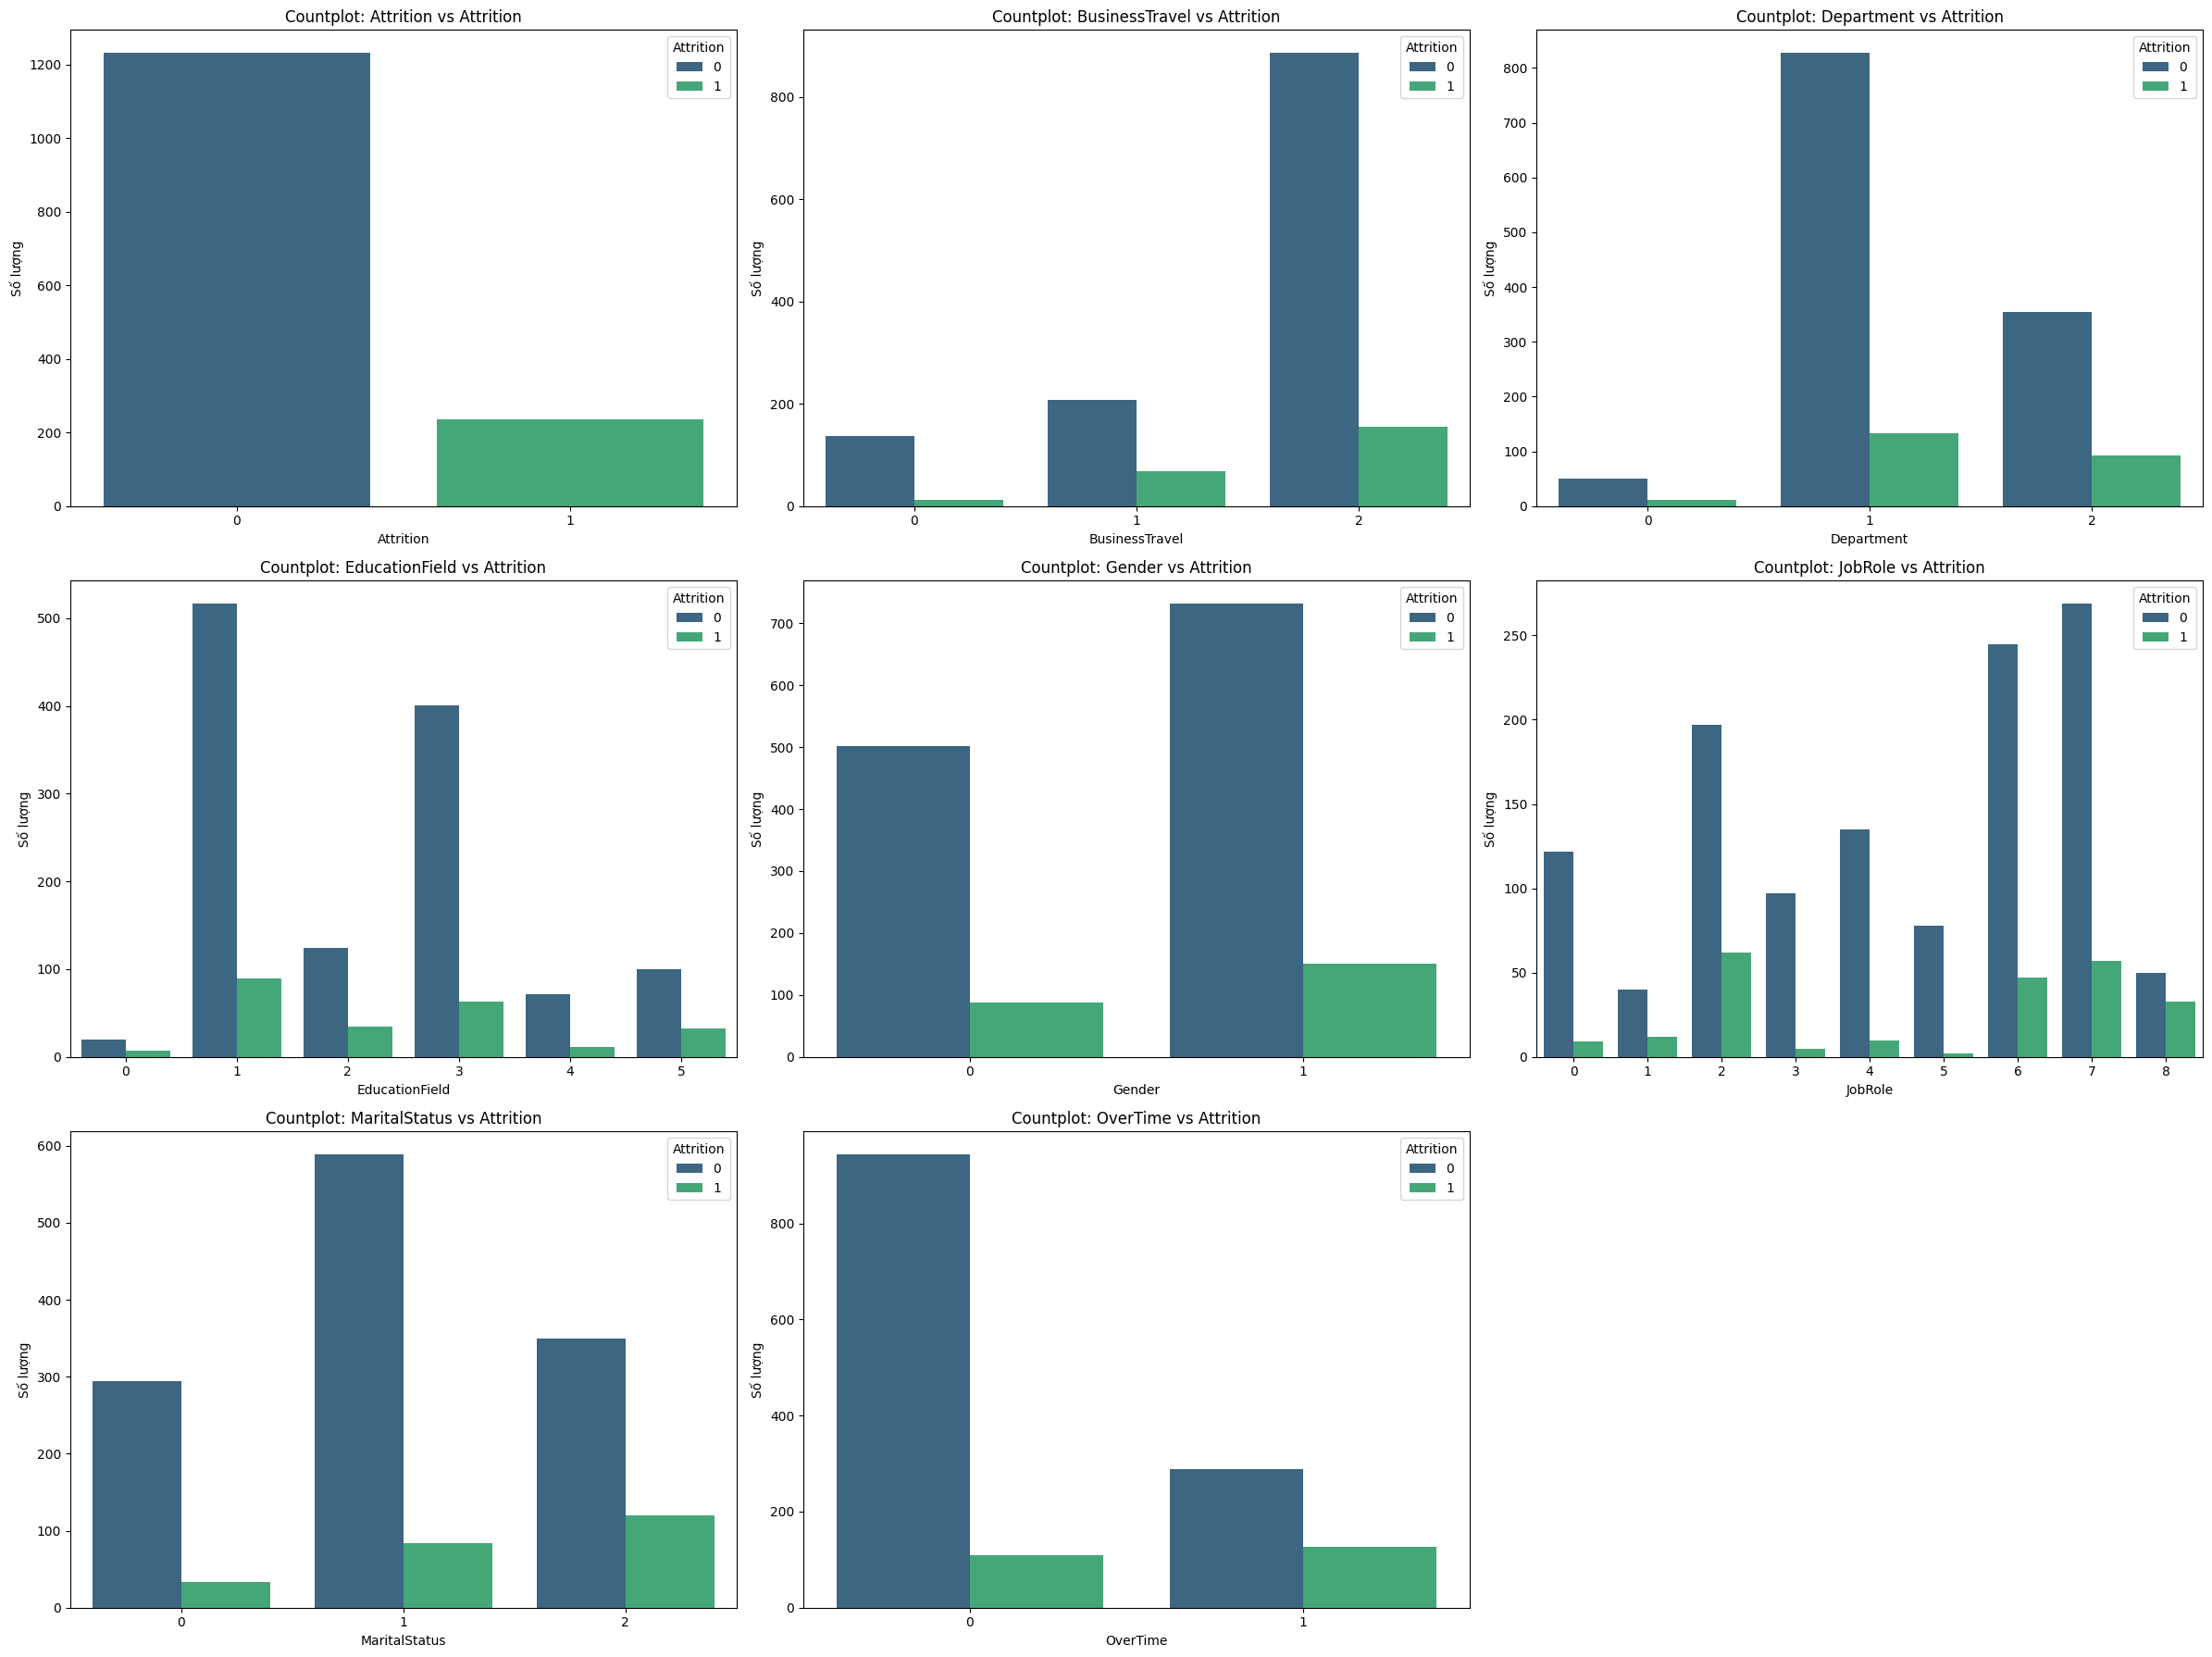

In [19]:
# Vẽ countplot giữa các biến phân loại và biến mục tiêu Attrition
plt.figure(figsize=(24, 18))
for idx, col in enumerate(categorical_cols):
    plt.subplot(3, 3, idx + 1)
    # Nếu cột đã được one-hot encoding, vẽ countplot cho từng biến mới liên quan
    related_cols = [c for c in df.columns if c.startswith(col + "_") or c == col]
    for rel_col in related_cols:
        sns.countplot(data=df, x=rel_col, hue='Attrition', palette='viridis')
        plt.title(f'Countplot: {rel_col} vs Attrition')
        plt.xlabel(rel_col)
        plt.ylabel('Số lượng')
    plt.title(f'Countplot: {col} vs Attrition')
    plt.xlabel(col)
    plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()

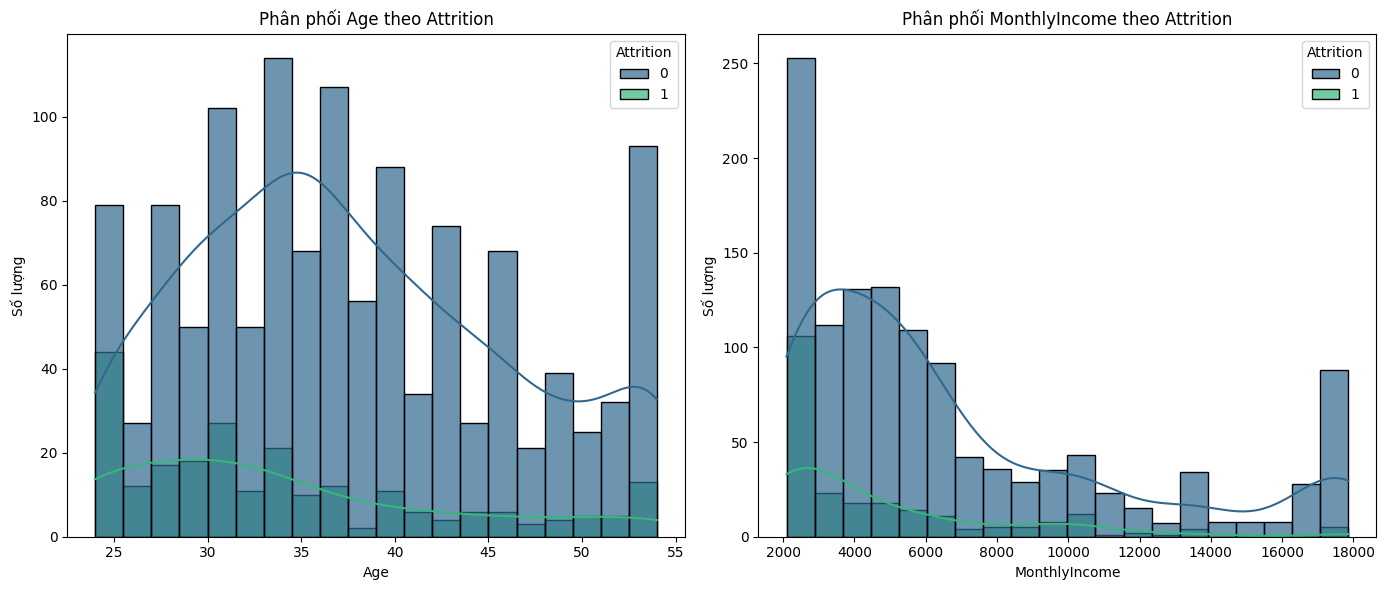

In [20]:
plt.figure(figsize=(14, 6))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối Age theo Attrition')
plt.xlabel('Age')
plt.ylabel('Số lượng')

# Histogram for MonthlyIncome
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='MonthlyIncome', hue='Attrition', bins=20, kde=True, palette='viridis', alpha=0.7)
plt.title('Phân phối MonthlyIncome theo Attrition')
plt.xlabel('MonthlyIncome')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

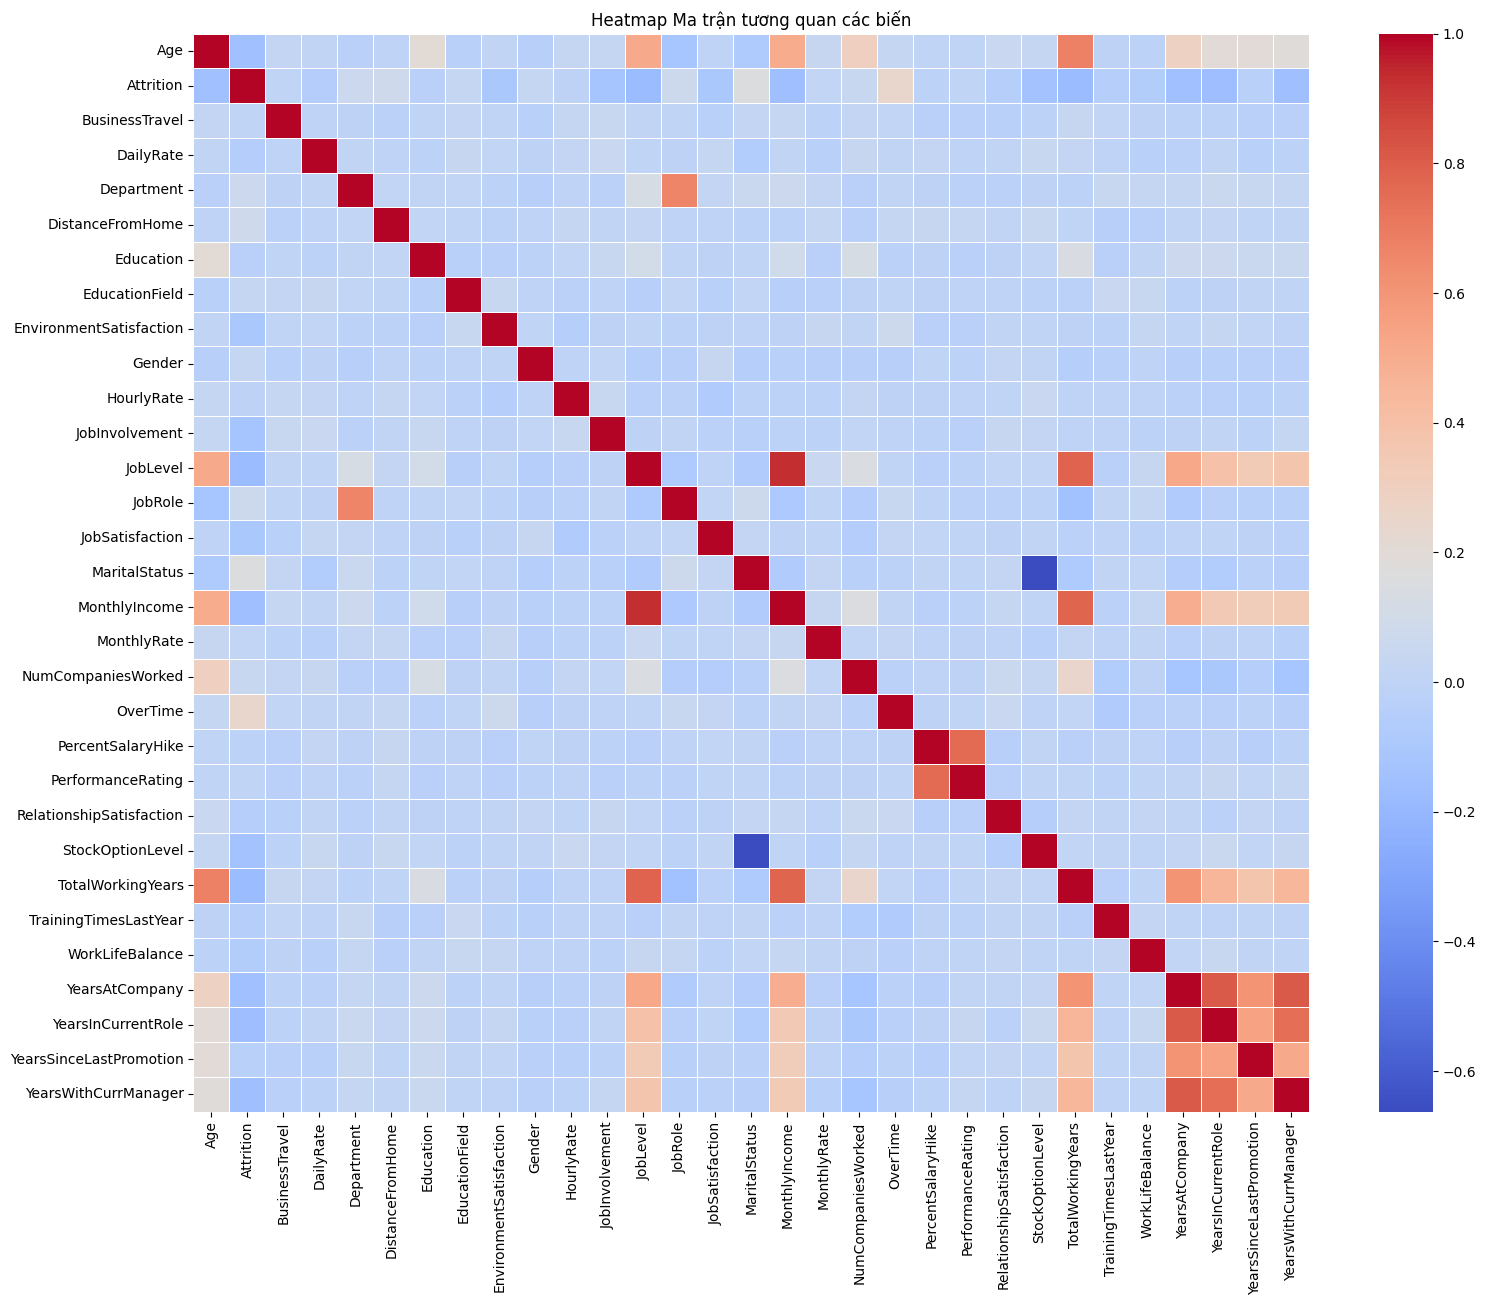

In [21]:
# Tính ma trận tương quan
corr_matrix = df.corr()

# Vẽ heatmap với seaborn
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Ma trận tương quan các biến')
plt.show()

In [22]:

print("Phân phối của biến mục tiêu 'Attrition':")
print(df['Attrition'].value_counts(normalize=True))
print(df['Attrition'].value_counts())

Phân phối của biến mục tiêu 'Attrition':
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64
Attrition
0    1233
1     237
Name: count, dtype: int64


*Chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình*

In [23]:
# chia bộ dữ liệu ra làm 2 phần 70/30 để huấn luyện mô hình
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Số lượng mẫu trong tập huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra: {X_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp:\n{y_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp:\n{y_test.value_counts()}")

# chia bộ dữ liệu đã loại bỏ outliers ra làm 2 phần 70/30
X_cleaned_outliers = df_cleaned_outliers.drop('Attrition', axis=1)
y_cleaned_outliers = df_cleaned_outliers['Attrition']
X_cleaned_outliers_train, X_cleaned_outliers_test, y_cleaned_outliers_train, y_cleaned_outliers_test = train_test_split(
	X_cleaned_outliers, y_cleaned_outliers, test_size=0.3, random_state=42, stratify=y_cleaned_outliers
)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): {X_cleaned_outliers_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): {X_cleaned_outliers_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_cleaned_outliers_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):\n{y_cleaned_outliers_test.value_counts()}")

# Chia bộ dữ liệu chỉ có 12 đặc trưng quan trọng nhất ra làm 2 phần 70/30
X_top_12 = df_top_12.drop('Attrition', axis=1)
y_top_12 = df_top_12['Attrition']
X_top_12_train, X_top_12_test, y_top_12_train, y_top_12_test = train_test_split(X_top_12, y_top_12, test_size=0.3, random_state=42, stratify=y_top_12)
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất): {X_top_12_train.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra (chỉ 12 đặc trưng quan trọng nhất): {X_top_12_test.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp (chỉ 12 đặc trưng quan trọng nhất):\n{y_top_12_train.value_counts()}")
print(f"Số lượng mẫu trong tập kiểm tra theo lớp (chỉ 12 đặc trưng quan trọng nhất):\n{y_top_12_test.value_counts()}")


Số lượng mẫu trong tập huấn luyện: 1029
Số lượng mẫu trong tập kiểm tra: 441
Số lượng mẫu trong tập huấn luyện theo lớp:
Attrition
0    863
1    166
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp:
Attrition
0    370
1     71
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi resample và loại bỏ ngoại lệ): 545
Số lượng mẫu trong tập kiểm tra (sau khi resample và loại bỏ ngoại lệ): 234
Số lượng mẫu trong tập huấn luyện theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
0    448
1     97
Name: count, dtype: int64
Số lượng mẫu trong tập kiểm tra theo lớp (sau khi resample và loại bỏ ngoại lệ):
Attrition
0    193
1     41
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất): 1029
Số lượng mẫu trong tập kiểm tra (chỉ 12 đặc trưng quan trọng nhất): 441
Số lượng mẫu trong tập huấn luyện theo lớp (chỉ 12 đặc trưng quan trọng nhất):
Attrition
0    863
1    166
Name: count, dtype: int64
Số lượng mẫu trong tập 

**Thực hiện Feature Scaling tập X để chuẩn hóa dữ liệu**

In [24]:
# Thực hiện Feature Scaling tập X để chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)     
X_cleaned_outliers_train = scaler.transform(X_cleaned_outliers_train)
X_cleaned_outliers_test = scaler.transform(X_cleaned_outliers_test)
X_top_12_train = scaler.fit_transform(X_top_12_train)
X_top_12_test = scaler.transform(X_top_12_test)

**Áp dụng RFECV để chọn các đặc trưng**

In [25]:
# Dùng RFECV để chọn các đặc trưng
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LogisticRegression(solver='liblinear', penalty='l1'), step=1, cv=5, scoring='f1')
rfecv.fit(X_train, y_train)
selected_features = rfecv.get_support(indices=True)
print("Chỉ số các đặc trưng được chọn bởi RFECV:")
print(selected_features)

# Tạo bộ dữ liệu mới chỉ với các đặc trưng được chọn bởi RFECV
X_train_rfecv = X_train[:, selected_features]
X_test_rfecv = X_test[:, selected_features]
print(f"Hình dạng của tập huấn luyện sau khi chọn đặc trưng: {X_train_rfecv.shape}")
print(f"Hình dạng của tập kiểm tra sau khi chọn đặc trưng: {X_test_rfecv.shape}")

Chỉ số các đặc trưng được chọn bởi RFECV:
[ 0  3  4  7  8 10 13 14 15 17 18 21 22 23 25 26 27 28 29]
Hình dạng của tập huấn luyện sau khi chọn đặc trưng: (1029, 19)
Hình dạng của tập kiểm tra sau khi chọn đặc trưng: (441, 19)


**Xử lý mất cân bằng dữ liệu dùng phương pháp SMOTE**

In [26]:
# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu huấn luyện
smote = SMOTE(random_state=42)
X_resampled_train, y_resampled_train = smote.fit_resample(X_train, y_train)
print(f"Số lượng mẫu trong tập huấn luyện sau khi resample: {X_resampled_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện theo lớp sau khi resample:\n{y_resampled_train.value_counts()}")

# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu đã loại bỏ outliers
smote_outliers = SMOTE(random_state=42)
X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train = smote_outliers.fit_resample(X_cleaned_outliers_train, y_cleaned_outliers_train)
print(f"Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) sau khi resample: {X_resampled_cleaned_outliers_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) theo lớp sau khi resample:\n{y_resampled_cleaned_outliers_train.value_counts()}")

# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu chỉ có 12 đặc trưng quan trọng nhất
smote_top_12 = SMOTE(random_state=42)
X_resampled_top_12_train, y_resampled_top_12_train = smote_top_12.fit_resample(X_top_12_train, y_top_12_train)
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) sau khi resample: {X_resampled_top_12_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) theo lớp sau khi resample:\n{y_resampled_top_12_train.value_counts()}")

# Xử lý mất cân bằng dữ liệu sử dụng SMOTE trên bộ dữ liệu chọn đặc trưng bởi RFECV
smote_selected = SMOTE(random_state=42)
X_resampled_rfecv_train, y_resampled_rfecv_train = smote_selected.fit_resample(X_train_rfecv, y_train)
print(f"Số lượng mẫu trong tập huấn luyện (chọn đặc trưng bởi RFECV) sau khi resample: {X_resampled_rfecv_train.shape[0]}")
print(f"Số lượng mẫu trong tập huấn luyện (chọn đặc trưng bởi RFECV) theo lớp sau khi resample:\n{y_resampled_rfecv_train.value_counts()}")


Số lượng mẫu trong tập huấn luyện sau khi resample: 1726
Số lượng mẫu trong tập huấn luyện theo lớp sau khi resample:
Attrition
0    863
1    863
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) sau khi resample: 896
Số lượng mẫu trong tập huấn luyện (sau khi loại bỏ outliers) theo lớp sau khi resample:
Attrition
1    448
0    448
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) sau khi resample: 1726
Số lượng mẫu trong tập huấn luyện (chỉ 12 đặc trưng quan trọng nhất) theo lớp sau khi resample:
Attrition
0    863
1    863
Name: count, dtype: int64
Số lượng mẫu trong tập huấn luyện (chọn đặc trưng bởi RFECV) sau khi resample: 1726
Số lượng mẫu trong tập huấn luyện (chọn đặc trưng bởi RFECV) theo lớp sau khi resample:
Attrition
0    863
1    863
Name: count, dtype: int64


**Tạo danh sách lưu lại các mô hình và tìm ra bộ dữ liệu giúp huấn luyện mô hình tốt nhất**

In [27]:

from sklearn.metrics import f1_score # Import thước đo F1
import joblib

GOLDEN_METRIC = lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1)


champion_models = {}
champion_scores = {}

def update_champion_list(model_object, model_name, experiment_name, 
                         X_test_data, y_test_data):
    """
    Hàm này sẽ tính điểm của mô hình mới và so sánh với mô hình tốt nhất hiện tại.
    Nếu tốt hơn, nó sẽ cập nhật vào 'champion_models'.
    """
    global champion_models, champion_scores, GOLDEN_METRIC
    
    try:
        y_pred_test = model_object.predict(X_test_data)
        current_score = GOLDEN_METRIC(y_test_data, y_pred_test)
        
        print(f"--- Đang kiểm tra: '{model_name}' từ '{experiment_name}'...")
        print(f"    Điểm F1 (lớp 1) hiện tại: {current_score:.4f}")

        if model_name not in champion_scores:
            # Nếu chưa có, mô hình này tự động là mô hình tốt nhất đầu tiên
            print(f"    >> KẾT QUẢ: Mô hình tốt nhất ĐẦU TIÊN! Đã lưu.")
            champion_models[model_name] = model_object
            champion_scores[model_name] = {
                'score': current_score,
                'experiment': experiment_name
            }
        else:
            # Nếu đã có, so sánh điểm
            existing_best_score = champion_scores[model_name]['score']
            if current_score > existing_best_score:
                # Mô hình mới tốt hơn -> Cập nhật mô hình 
                print(f"    >> KẾT QUẢ: MỚI! Tốt hơn mô hình cũ ( {existing_best_score:.4f} ). Đã cập nhật.")
                champion_models[model_name] = model_object
                champion_scores[model_name] = {
                    'score': current_score,
                    'experiment': experiment_name
                }
            else:
                # Mô hình mới kém hơn -> Bỏ qua
                print(f"    >> KẾT QUẢ: CŨ! Không tốt bằng mô hình hiện tại ( {existing_best_score:.4f} ). Bỏ qua.")
                
    except Exception as e:
        print(f"    LỖI khi đánh giá '{model_name}': {e}")
    
    print("-" * 30)

print("Đã khởi tạo Bảng đánh giá và hàm update_champion_list() thành công.")

Đã khởi tạo Bảng đánh giá và hàm update_champion_list() thành công.


# Xây dựng mô hình

**Xây dựng mô hình với bộ dữ liệu gốc chỉ qua các bước tiền xử lý**

--> Đã chọn K=4

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       370
           1       0.70      0.32      0.44        71

    accuracy                           0.87       441
   macro avg       0.79      0.65      0.68       441
weighted avg       0.85      0.87      0.85       441

Confusion Matrix cho Logistic Regression...


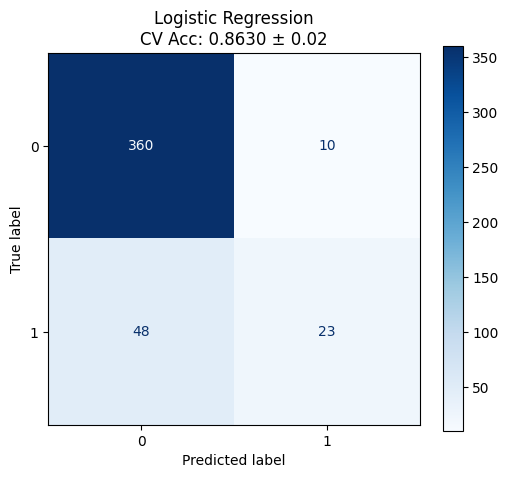


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       370
           1       0.28      0.25      0.26        71

    accuracy                           0.77       441
   macro avg       0.57      0.56      0.57       441
weighted avg       0.77      0.77      0.77       441

Confusion Matrix cho Decision Tree...


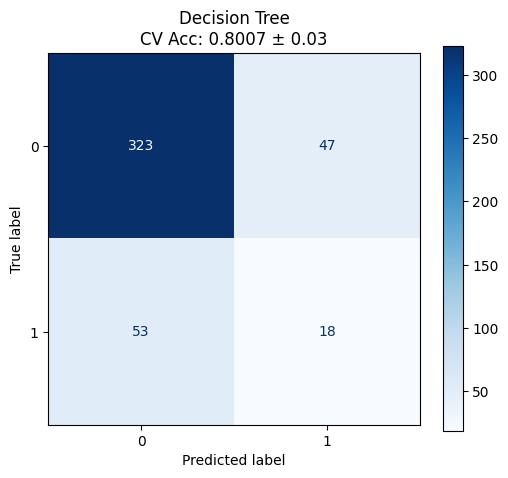


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       370
           1       0.42      0.11      0.18        71

    accuracy                           0.83       441
   macro avg       0.64      0.54      0.54       441
weighted avg       0.78      0.83      0.79       441

Confusion Matrix cho Random Forest...


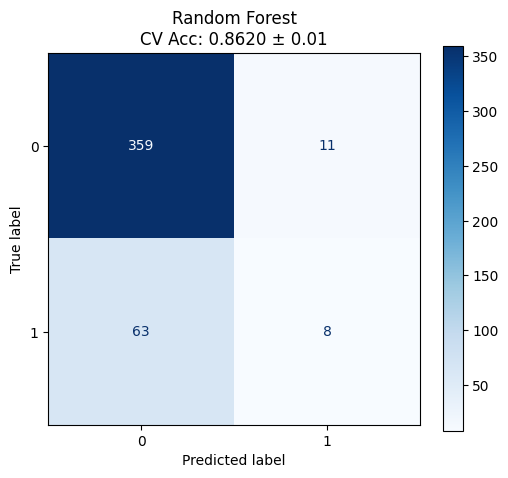


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       370
           1       0.88      0.10      0.18        71

    accuracy                           0.85       441
   macro avg       0.86      0.55      0.55       441
weighted avg       0.86      0.85      0.80       441

Confusion Matrix cho KNN...


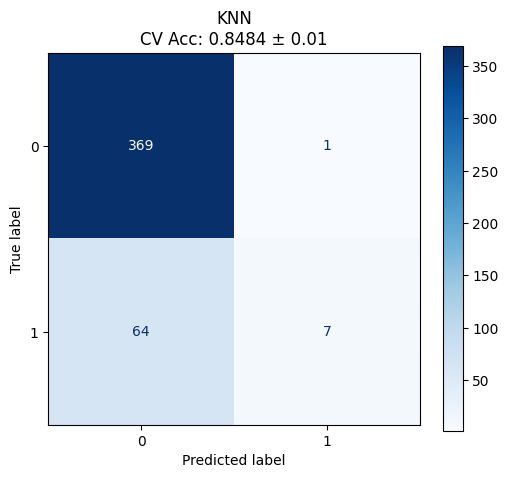

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:23] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.62      0.23      0.33        71

    accuracy                           0.85       441
   macro avg       0.74      0.60      0.62       441
weighted avg       0.83      0.85      0.82       441

Confusion Matrix cho XGBoost...


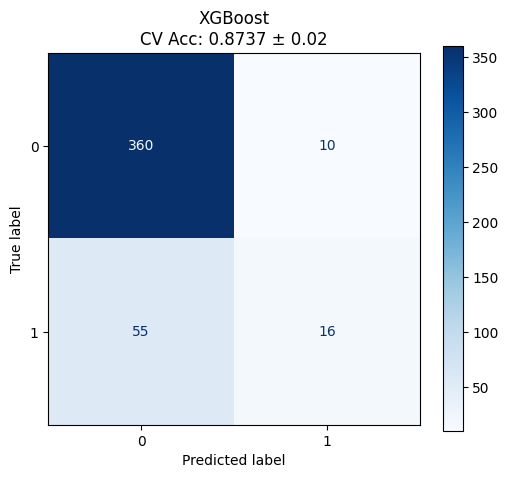


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.61      0.24      0.34        71

    accuracy                           0.85       441
   macro avg       0.74      0.60      0.63       441
weighted avg       0.83      0.85      0.82       441

Confusion Matrix cho LightGBM...


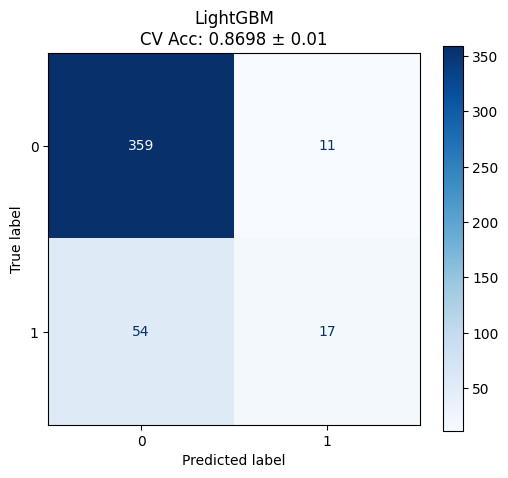


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       370
           1       0.71      0.17      0.27        71

    accuracy                           0.85       441
   macro avg       0.78      0.58      0.60       441
weighted avg       0.84      0.85      0.82       441

Confusion Matrix cho SVM...


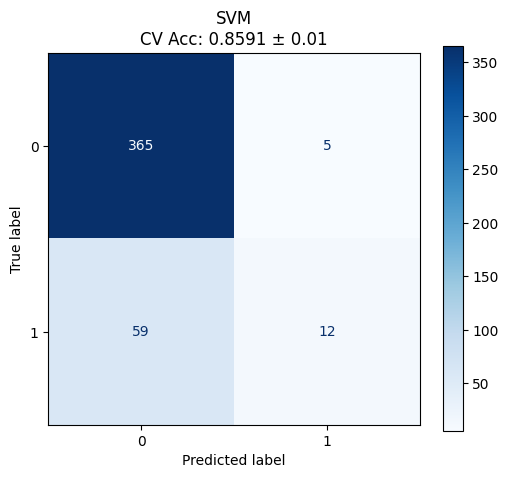

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       370
           1       0.34      0.18      0.24        71

    accuracy                           0.81       441
   macro avg       0.60      0.56      0.57       441
weighted avg       0.77      0.81      0.79       441

Confusion Matrix cho TabNet...


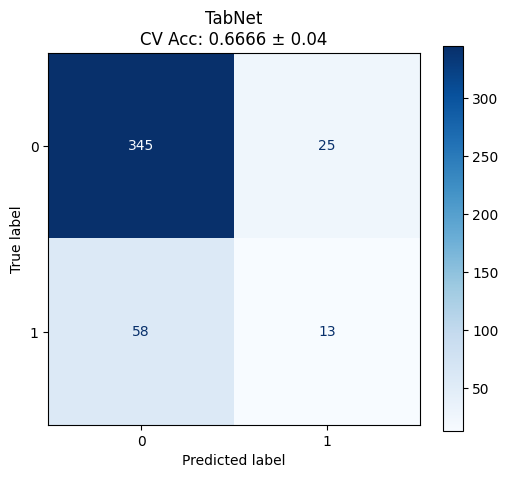

Mô hình Accuracy (Mean ± SD) F1-Score (Mean ± SD)
0  Logistic Regression        0.8630 ± 0.02        0.6806 ± 0.06
1        Decision Tree        0.8007 ± 0.03        0.6436 ± 0.05
2        Random Forest        0.8620 ± 0.01        0.6166 ± 0.06
3                  KNN        0.8484 ± 0.01        0.5280 ± 0.05
4              XGBoost        0.8737 ± 0.02        0.6910 ± 0.06
5             LightGBM        0.8698 ± 0.01        0.6798 ± 0.04
6                  SVM        0.8591 ± 0.01        0.5988 ± 0.05
7               TabNet        0.6666 ± 0.04        0.5026 ± 0.05

In [28]:
def train_evaluate_full_version(models, X_train, y_train, X_test, y_test, cv=5):
    
    # Chuyển dữ liệu sang numpy
    def _to_array(data):
        return data.values if isinstance(data, (pd.DataFrame, pd.Series)) else data

    X_train_np = _to_array(X_train)
    y_train_np = _to_array(y_train)
    X_test_np = _to_array(X_test)
    y_test_np = _to_array(y_test)

    results = [] 

    for name, model in models.items():
        acc_mean, acc_std = 0, 0
        f1_mean, f1_std = 0, 0
        try:
            # Tính Accuracy
            cv_acc = cross_val_score(model, X_train_np, y_train_np, cv=cv, scoring='accuracy')
            acc_mean = cv_acc.mean()
            acc_std = cv_acc.std()
            
            # Tính F1-Score
            cv_f1 = cross_val_score(model, X_train_np, y_train_np, cv=cv, scoring='f1_macro')
            f1_mean = cv_f1.mean()
            f1_std = cv_f1.std()
            
        except Exception as e:
            print(f"Lỗi CV: {e}")

        if name == 'TabNet':
            model.fit(X_train_np, y_train_np, max_epochs=50, batch_size=1024, virtual_batch_size=128)
        else:
            model.fit(X_train_np, y_train_np)

        y_pred = model.predict(X_test_np)
        
        print("\nBáo cáo phân loại (Classification Report):")
        print(classification_report(y_test_np, y_pred))
        
        print(f"Confusion Matrix cho {name}...")
        cm = confusion_matrix(y_test_np, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        
        fig, ax = plt.subplots(figsize=(6, 5))
        disp.plot(cmap='Blues', values_format='d', ax=ax)
        
        plt.title(f'{name}\nCV Acc: {acc_mean:.4f} ± {acc_std:.2f}')
        plt.show()

        results.append({
            'Mô hình': name,
            'Accuracy (Mean ± SD)': f"{acc_mean:.4f} ± {acc_std:.2f}",
            'F1-Score (Mean ± SD)': f"{f1_mean:.4f} ± {f1_std:.2f}"
        })

    return pd.DataFrame(results)

best_k = 1
best_acc = 0
X_tr_val = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_tr_val = y_train.values if isinstance(y_train, pd.Series) else y_train
X_te_val = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_te_val = y_test.values if isinstance(y_test, pd.Series) else y_test

for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_val, y_tr_val)
    score = knn.score(X_te_val, y_te_val)
    if score > best_acc:
        best_acc = score
        best_k = k
print(f"--> Đã chọn K={best_k}")

models_list = {
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}
df_final_full = train_evaluate_full_version(models_list, X_train, y_train, X_test, y_test)
display(df_final_full)

model        = models_list["Logistic Regression"] 
model_dt     = models_list["Decision Tree"]
model_rf     = models_list["Random Forest"]
model_knn    = models_list["KNN"]
model_xgb    = models_list["XGBoost"]
model_lgb    = models_list["LightGBM"]
model_svm    = models_list["SVM"]
model_tabnet = models_list["TabNet"]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns, plot_type="bar", show=False)


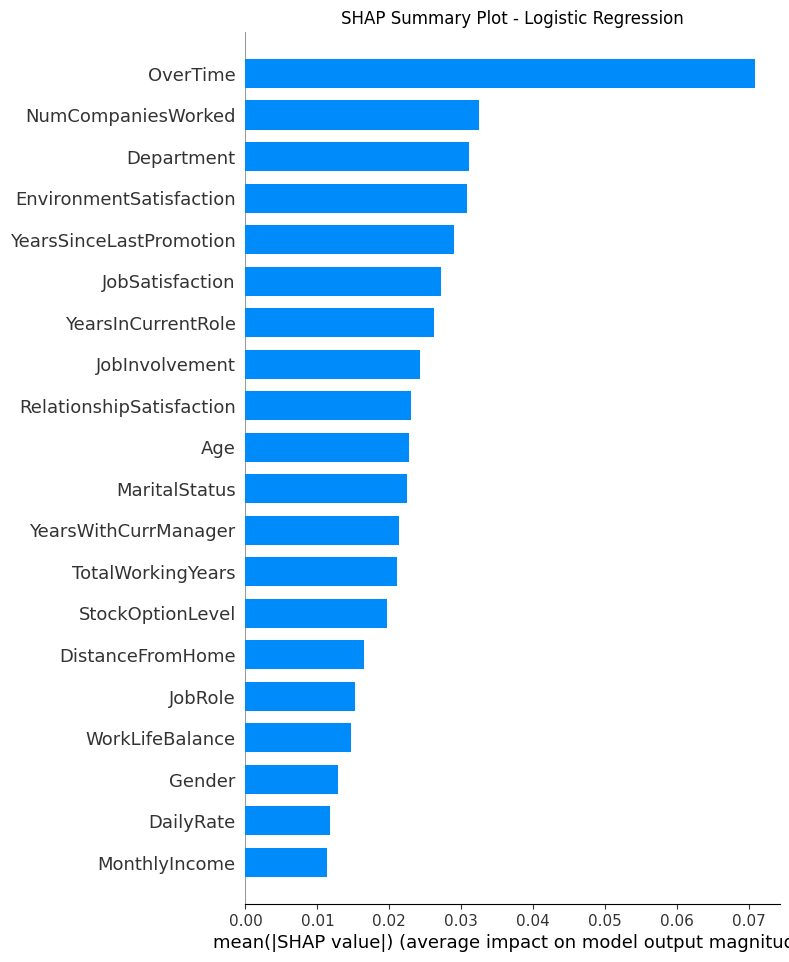

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_dt, X_test, feature_names=X.columns, plot_type="bar", show=False)


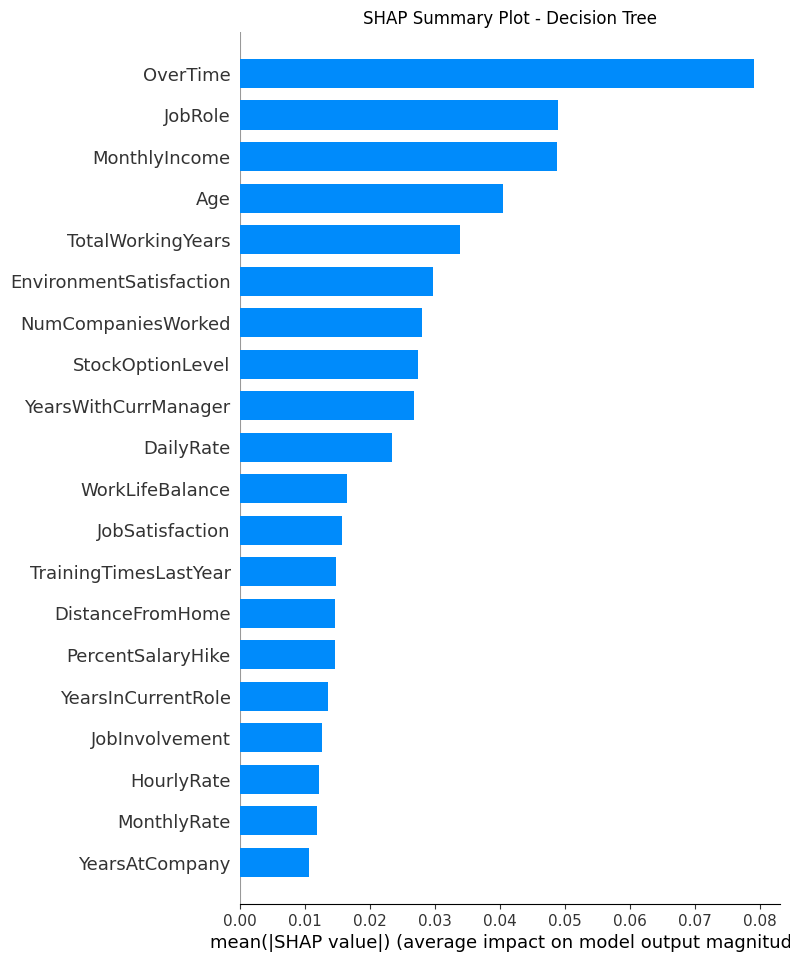

PermutationExplainer explainer: 442it [01:06,  5.51it/s]                         
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, plot_type="bar", show=False)


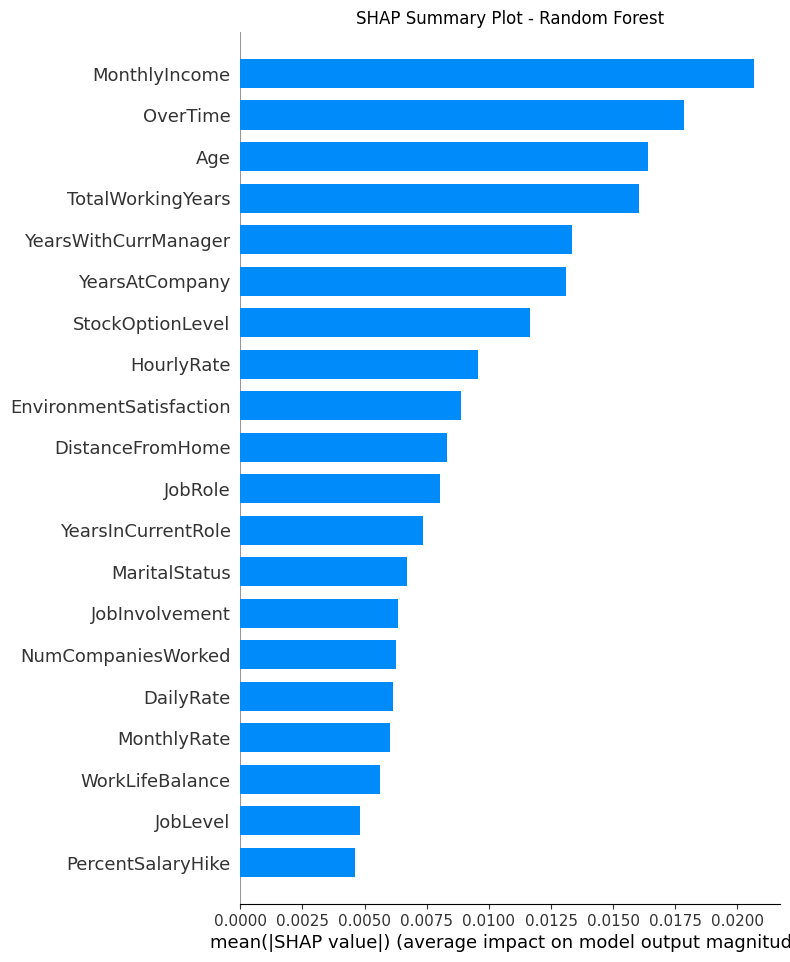

PermutationExplainer explainer: 442it [00:49,  6.99it/s]                         
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_knn, X_test, feature_names=X.columns, plot_type="bar", show=False)


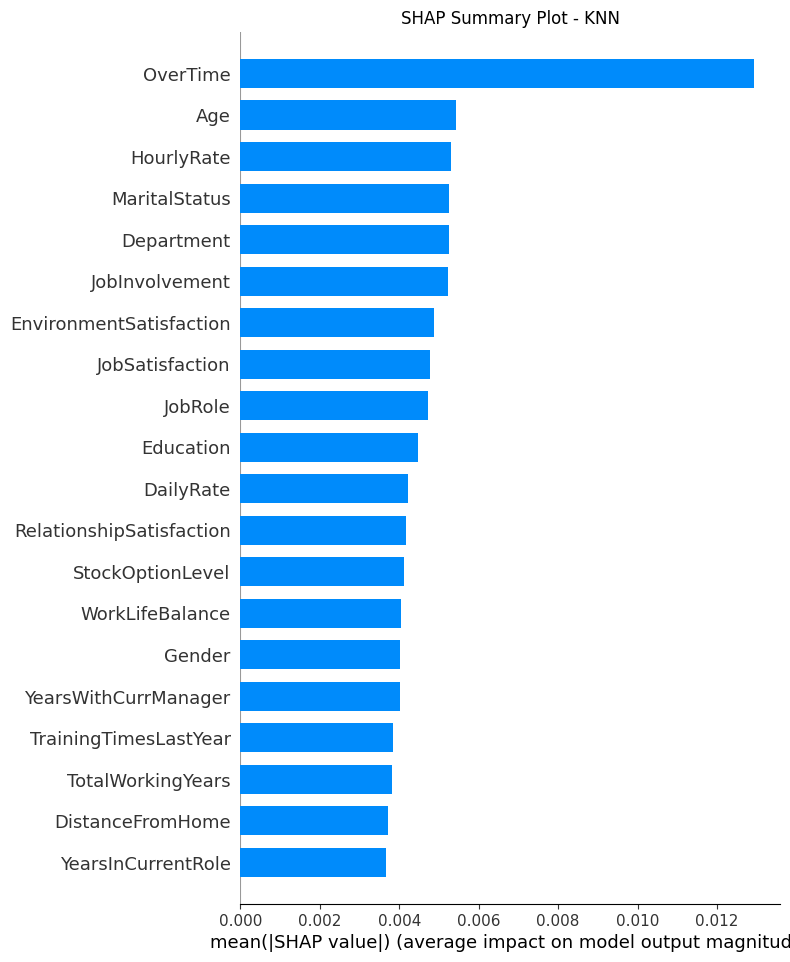

PermutationExplainer explainer: 442it [00:14,  9.14it/s]                         
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, plot_type="bar", show=False)


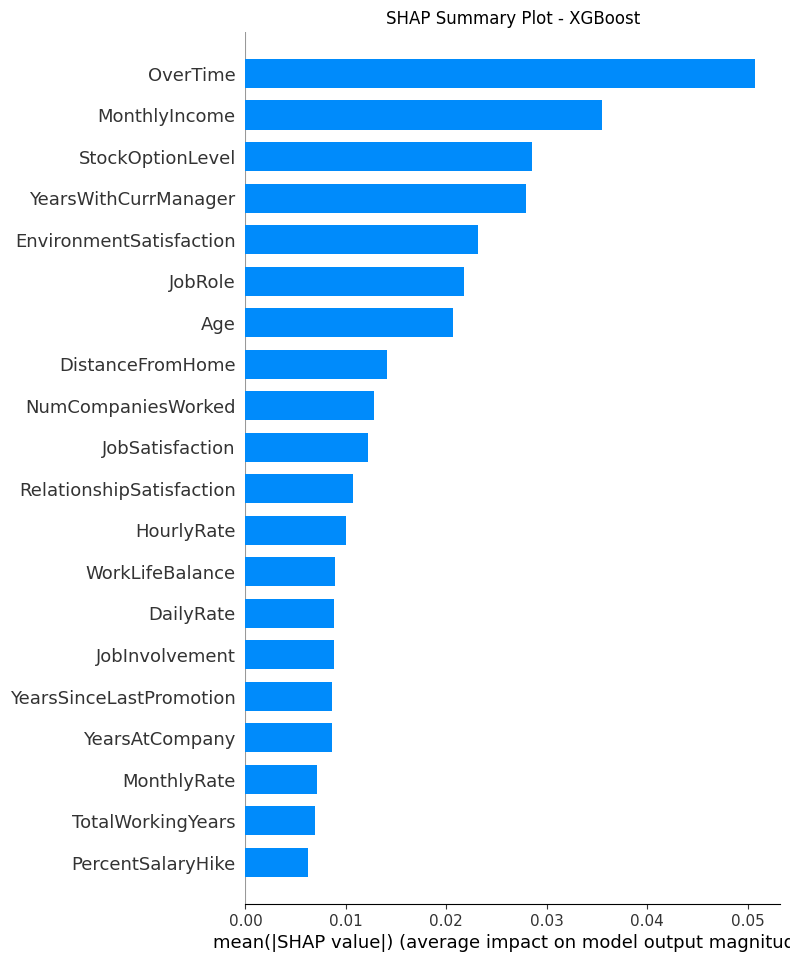

PermutationExplainer explainer: 442it [00:35,  8.79it/s]                         
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\1834470538.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lgb, X_test, feature_names=X.columns, plot_type="bar", show=False)


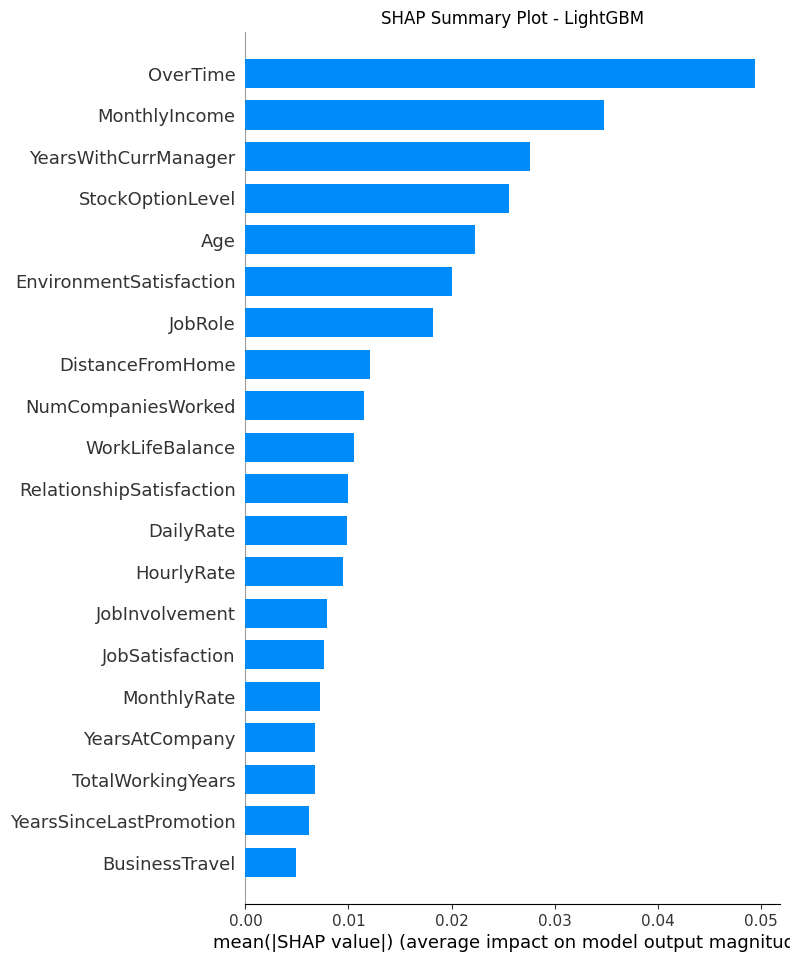

PermutationExplainer explainer: 442it [09:25,  1.31s/it]                         

Không thể tạo SHAP cho SVM: 'numpy.ndarray' object has no attribute 'columns'
Không thể tạo SHAP cho TabNet: name 'X_tabnet' is not defined


In [29]:
# Dùng SHAP để diễn giải tất cả các mô hình đã huấn luyện
explainer_lr = shap.Explainer(model.predict, X_train)
shap_values_lr = explainer_lr(X_test)
shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Logistic Regression")
plt.show()
explainer_dt = shap.Explainer(model_dt.predict, X_train)
shap_values_dt = explainer_dt(X_test)
shap.summary_plot(shap_values_dt, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Decision Tree")
plt.show()
explainer_rf = shap.Explainer(model_rf.predict, X_train)
shap_values_rf = explainer_rf(X_test)
shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Random Forest")
plt.show()
explainer_knn = shap.Explainer(model_knn.predict, X_train)
shap_values_knn = explainer_knn(X_test)
shap.summary_plot(shap_values_knn, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - KNN")
plt.show()
explainer_xgb = shap.Explainer(model_xgb.predict, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.show()
explainer_lgb = shap.Explainer(model_lgb.predict, X_train)
shap_values_lgb = explainer_lgb(X_test)
shap.summary_plot(shap_values_lgb, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - LightGBM")
plt.show()
try:
	explainer_svm = shap.Explainer(model_svm.predict, X_train)
	shap_values_svm = explainer_svm(X_test)
	if isinstance(shap_values_svm, list):
		vals = shap_values_svm[1]  # Lấy giá trị SHAP cho lớp dương
	else:
		vals = shap_values_svm
	shap.summary_plot(vals, X_test, plot_type="bar", feature_names=X_test.columns, show=False)
	plt.title("Tầm quan trọng của các đặc trưng - SVM")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho SVM:", e)
try:
	explainer_tabnet = shap.Explainer(model_tabnet.predict, X_tabnet)
	shap_values_tabnet = explainer_tabnet(X_test_tabnet)
	shap.summary_plot(shap_values_tabnet, X_test_tabnet, feature_names=X.columns, plot_type="bar", show=False)
	plt.title("SHAP Summary Plot - TabNet")
	plt.show()
except Exception as e:
	print("Không thể tạo SHAP cho TabNet:", e)

In [30]:
# Dùng tensorflow để so sánh các mô hình đã huấn luyện
def SoSanhCacModel(models, X_test, y_test, figsize=(20, 8)):
    # Hàm phụ trợ để chuyển đổi dữ liệu sang numpy array
    def _to_array(X):
        return X if isinstance(X, np.ndarray) else getattr(X, "values", X)

    results = {} 
    
    print("Đang tính toán dự đoán...")
    for name, mdl in models.items():
        try:
            X_input = _to_array(X_test)
            y_probs = None
            
            if name == "TabNet":
                y_probs = mdl.predict_proba(X_input)[:, 1]
            else:
                if hasattr(mdl, "predict_proba"):
                    y_probs = mdl.predict_proba(X_input)[:, 1]
                elif hasattr(mdl, "decision_function"):
                    y_probs = mdl.decision_function(X_input)
                else:
                    y_probs = mdl.predict(X_input)
            
            # Tính AUC
            auc = roc_auc_score(y_test, y_probs)
            
            results[name] = {
                'auc': auc,
                'y_probs': y_probs
            }
            
        except Exception as e:
            print(f"Lỗi khi đánh giá mô hình {name}: {e}")
            results[name] = {'auc': np.nan, 'y_probs': None}

    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]['auc'] if not np.isnan(item[1]['auc']) else -1, reverse=True))
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    model_names = list(sorted_results.keys())
    auc_values = [sorted_results[m]['auc'] for m in model_names]
    
    sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
    axes[0].set_title('So sánh AUC Score giữa các mô hình')
    axes[0].set_ylabel('AUC Score')
    axes[0].set_ylim(0, 1.05)
    axes[0].tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(auc_values):
        if not np.isnan(v):
            axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')

    for name, data in sorted_results.items():
        if data['y_probs'] is not None:
            fpr, tpr, _ = roc_curve(y_test, data['y_probs'])
            axes[1].plot(fpr, tpr, label=f"{name} (AUC = {data['auc']:.4f})")
    
    axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curves')
    axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


**Xây dựng mô hình với dữ liệu gốc qua Resample bằng SMOTE**

--> K tối ưu cho Resampled là: 2

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       370
           1       0.39      0.73      0.51        71

    accuracy                           0.78       441
   macro avg       0.67      0.76      0.68       441
weighted avg       0.85      0.78      0.80       441

Confusion Matrix cho Logistic Regression...


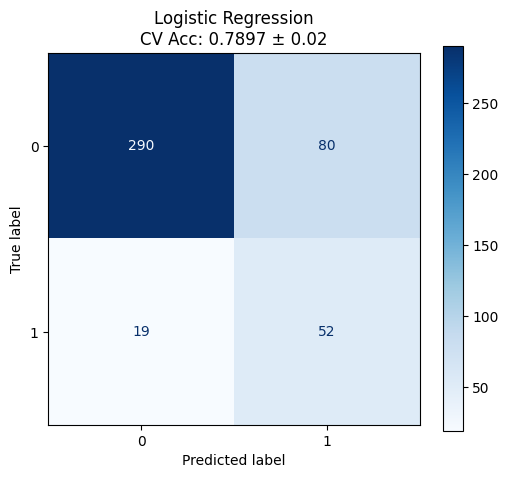


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       370
           1       0.31      0.38      0.34        71

    accuracy                           0.76       441
   macro avg       0.59      0.61      0.60       441
weighted avg       0.78      0.76      0.77       441

Confusion Matrix cho Decision Tree...


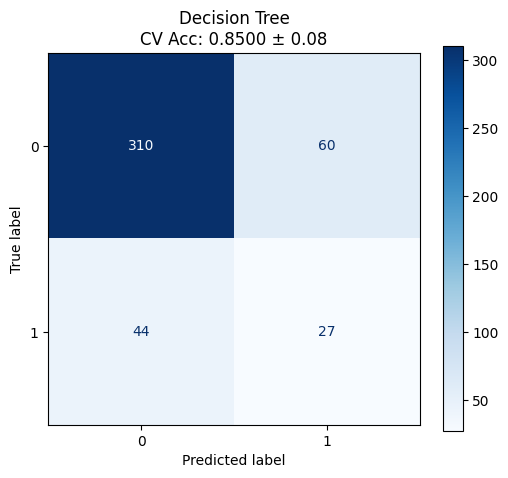


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       370
           1       0.53      0.23      0.32        71

    accuracy                           0.84       441
   macro avg       0.70      0.59      0.61       441
weighted avg       0.81      0.84      0.82       441

Confusion Matrix cho Random Forest...


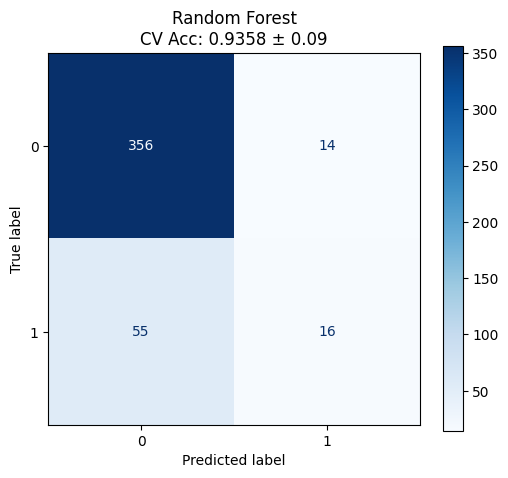


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       370
           1       0.30      0.35      0.32        71

    accuracy                           0.76       441
   macro avg       0.59      0.60      0.59       441
weighted avg       0.78      0.76      0.77       441

Confusion Matrix cho KNN...


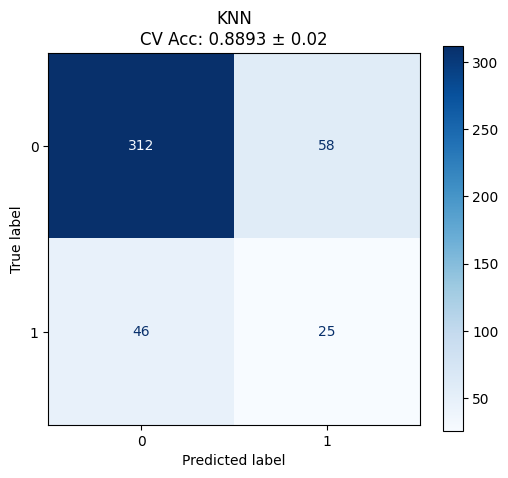

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:01] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       370
           1       0.67      0.31      0.42        71

    accuracy                           0.86       441
   macro avg       0.77      0.64      0.67       441
weighted avg       0.85      0.86      0.84       441

Confusion Matrix cho XGBoost...


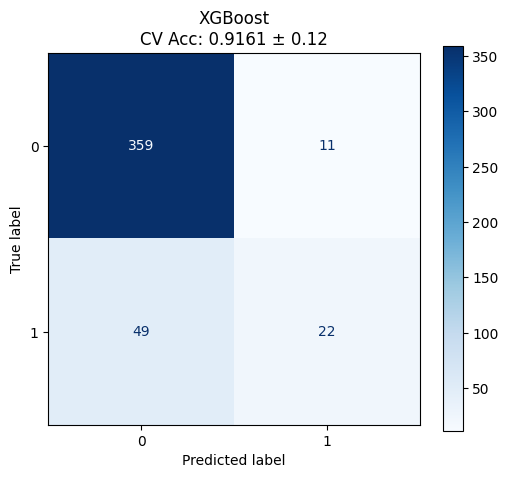


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       370
           1       0.61      0.28      0.38        71

    accuracy                           0.85       441
   macro avg       0.74      0.62      0.65       441
weighted avg       0.83      0.85      0.83       441

Confusion Matrix cho LightGBM...


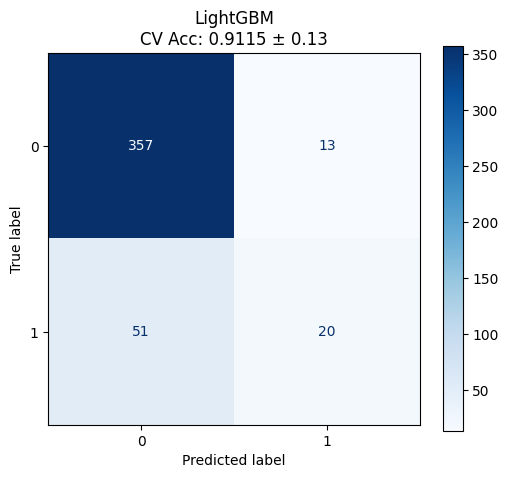


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       370
           1       0.54      0.46      0.50        71

    accuracy                           0.85       441
   macro avg       0.72      0.69      0.71       441
weighted avg       0.84      0.85      0.85       441

Confusion Matrix cho SVM...


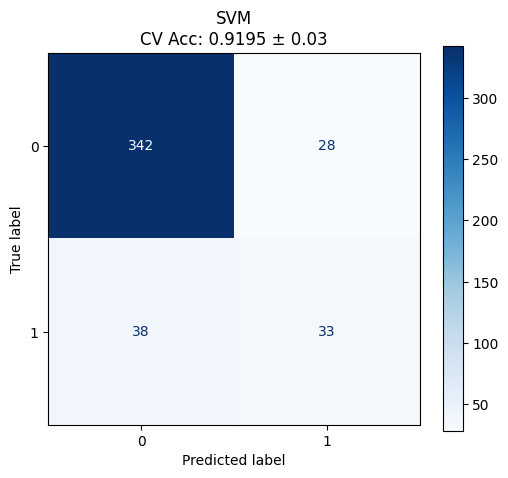

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       370
           1       0.25      0.58      0.34        71

    accuracy                           0.65       441
   macro avg       0.57      0.62      0.55       441
weighted avg       0.79      0.65      0.69       441

Confusion Matrix cho TabNet...


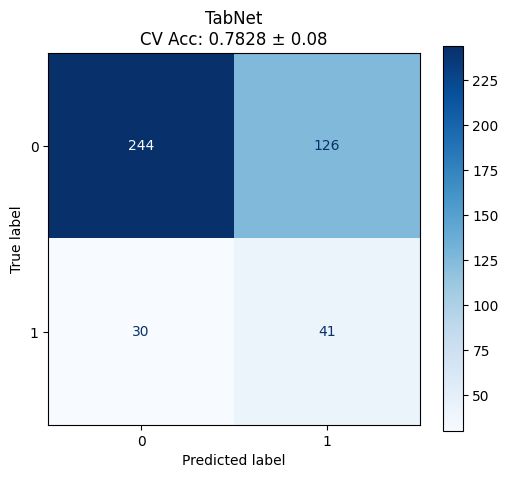

In [31]:
best_k_res = 1
best_acc_res = 0

X_tr_res = X_resampled_train.values if isinstance(X_resampled_train, pd.DataFrame) else X_resampled_train
y_tr_res = y_resampled_train.values if isinstance(y_resampled_train, pd.Series) else y_resampled_train
X_te_real = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_te_real = y_test.values if isinstance(y_test, pd.Series) else y_test

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_res, y_tr_res)
    score = knn.score(X_te_real, y_te_real)
    if score > best_acc_res:
        best_acc_res = score
        best_k_res = k
print(f"--> K tối ưu cho Resampled là: {best_k_res}")

models_list_resampled = {
    "Logistic Regression": LogisticRegression(solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_res), # Dùng K mới
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}

df_final_resampled = train_evaluate_full_version(
    models_list_resampled, 
    X_resampled_train, 
    y_resampled_train, 
    X_test, 
    y_test
)

model_res_lr     = models_list_resampled["Logistic Regression"]
model_res_dt     = models_list_resampled["Decision Tree"]
model_res_rf     = models_list_resampled["Random Forest"]
model_res_knn    = models_list_resampled["KNN"]
model_res_xgb    = models_list_resampled["XGBoost"]
model_res_lgb    = models_list_resampled["LightGBM"]
model_res_svm    = models_list_resampled["SVM"]
model_res_tabnet = models_list_resampled["TabNet"]

Đang tính toán dự đoán...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên


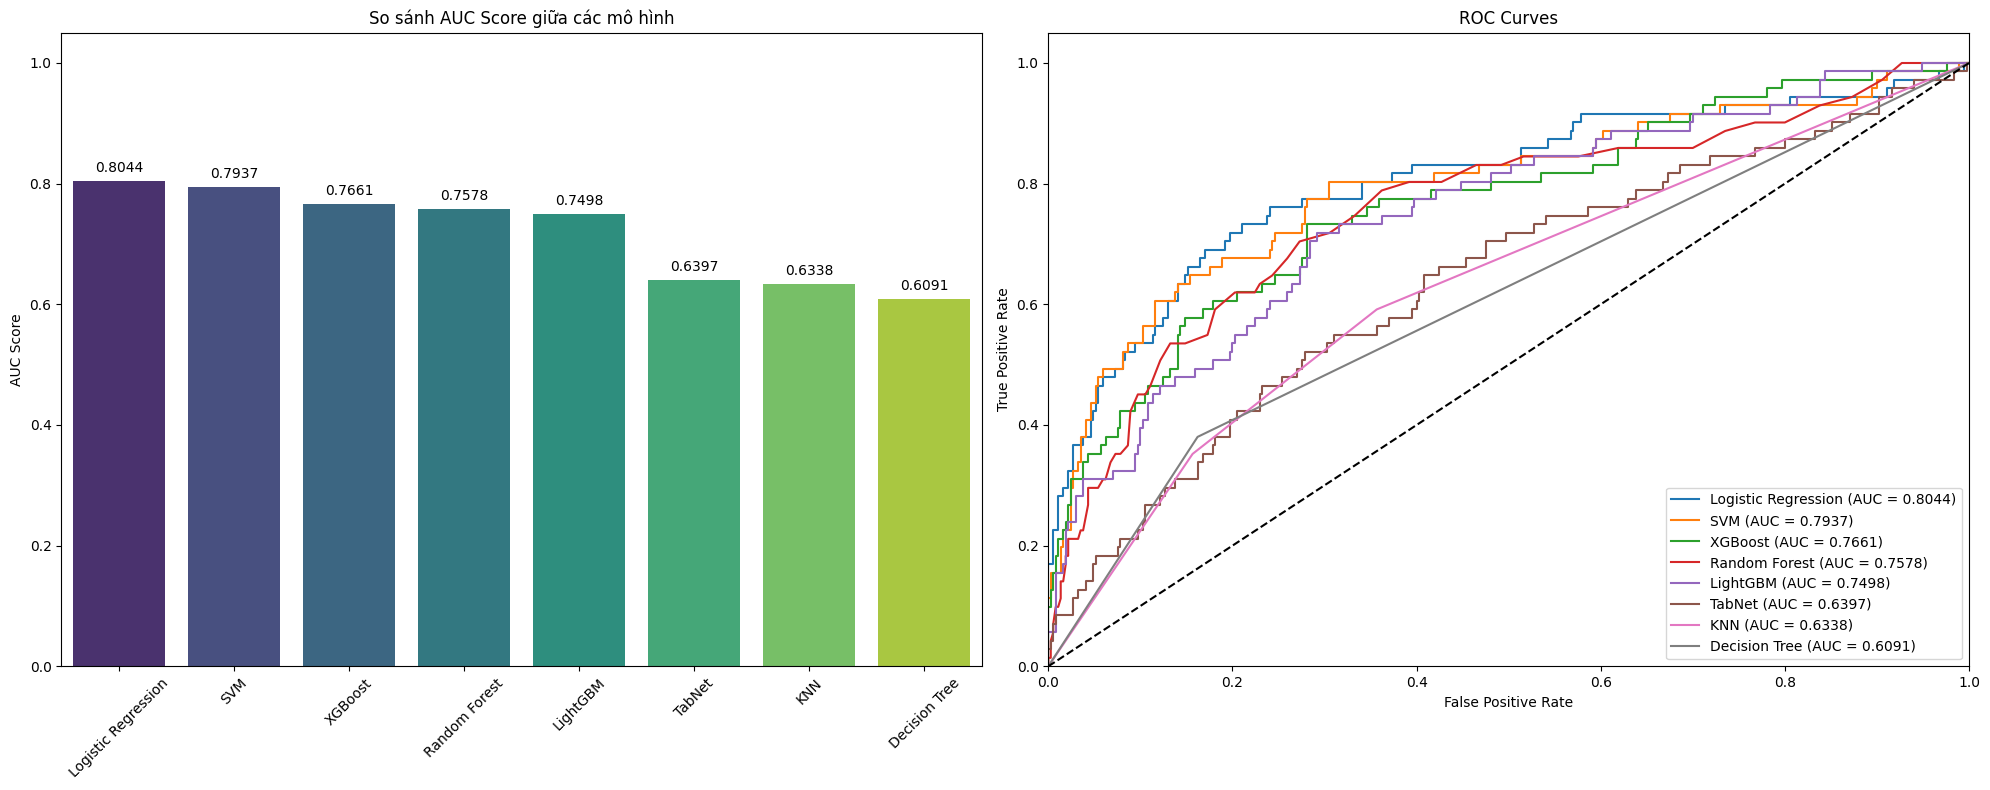

In [32]:
models = {
    "Logistic Regression": model_res_lr,
    "Decision Tree": model_res_dt,
    "Random Forest": model_res_rf,
    "KNN": model_res_knn,
    "XGBoost": model_res_xgb,
    "LightGBM": model_res_lgb,
    "SVM": model_svm,
    "TabNet": model_tabnet
}
SoSanhCacModel(models, X_test, y_test)

**Xây dựng mô hình với bộ dữ liệu đã qua resample bằng phương pháp SMOTE và loại bỏ outliers bằng IQR**

🔍 Đang tìm K tối ưu cho dữ liệu Cleaned + Resampled...
--> K tối ưu là: 2 (Acc: 0.7350)

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       193
           1       0.38      0.73      0.50        41

    accuracy                           0.75       234
   macro avg       0.66      0.74      0.67       234
weighted avg       0.83      0.75      0.77       234

Confusion Matrix cho Logistic Regression...


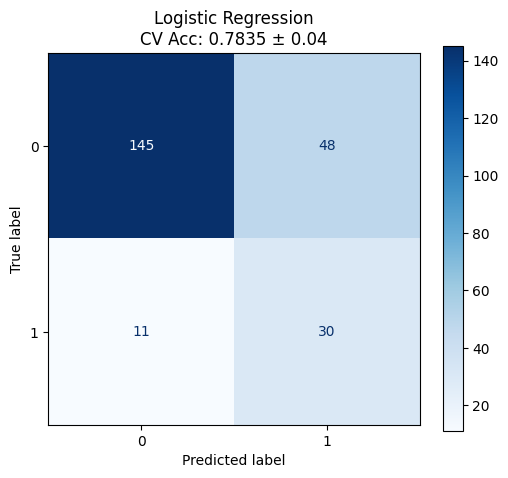


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       193
           1       0.32      0.44      0.37        41

    accuracy                           0.74       234
   macro avg       0.60      0.62      0.60       234
weighted avg       0.77      0.74      0.75       234

Confusion Matrix cho Decision Tree...


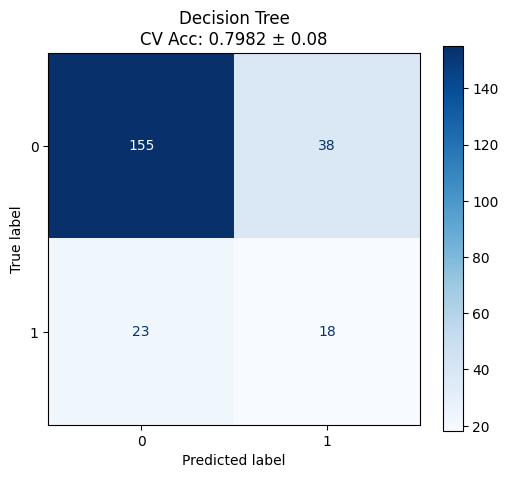


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       193
           1       0.67      0.34      0.45        41

    accuracy                           0.85       234
   macro avg       0.77      0.65      0.68       234
weighted avg       0.84      0.85      0.83       234

Confusion Matrix cho Random Forest...


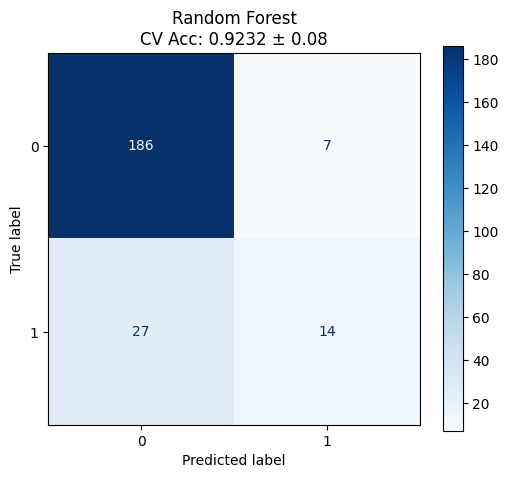


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       193
           1       0.32      0.46      0.38        41

    accuracy                           0.74       234
   macro avg       0.60      0.63      0.61       234
weighted avg       0.78      0.74      0.75       234

Confusion Matrix cho KNN...


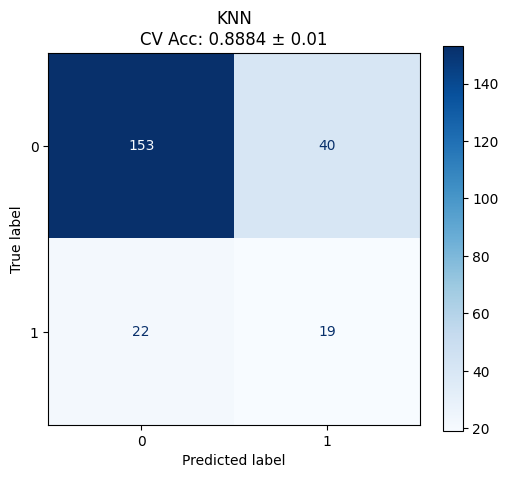

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:28:52] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       193
           1       0.71      0.49      0.58        41

    accuracy                           0.88       234
   macro avg       0.81      0.72      0.75       234
weighted avg       0.87      0.88      0.87       234

Confusion Matrix cho XGBoost...


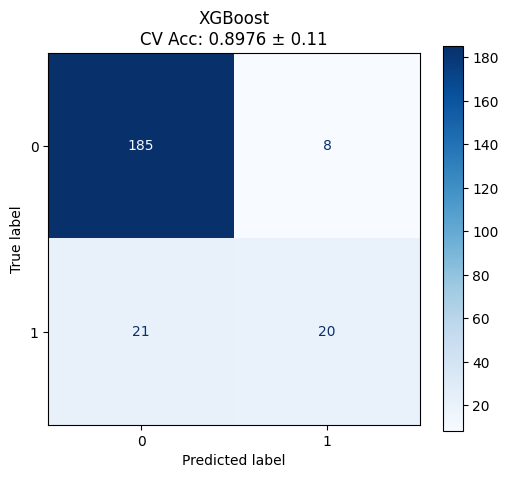


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       193
           1       0.75      0.37      0.49        41

    accuracy                           0.87       234
   macro avg       0.81      0.67      0.71       234
weighted avg       0.86      0.87      0.85       234

Confusion Matrix cho LightGBM...


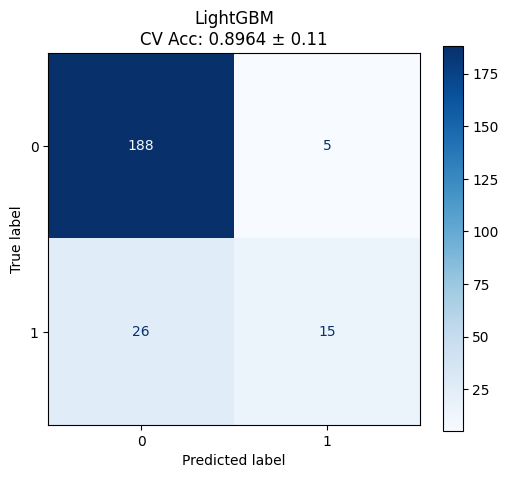


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       193
           1       0.46      0.44      0.45        41

    accuracy                           0.81       234
   macro avg       0.67      0.67      0.67       234
weighted avg       0.81      0.81      0.81       234

Confusion Matrix cho SVM...


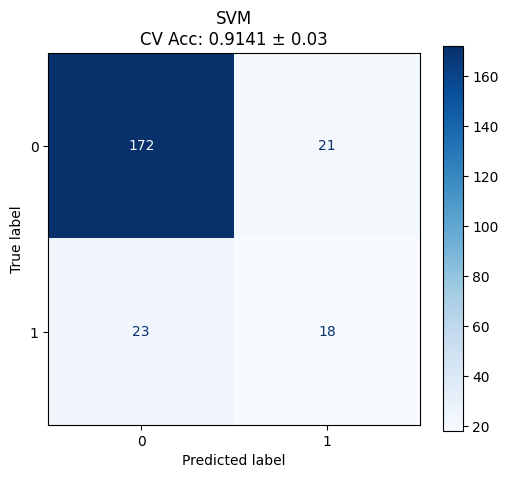

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.84      0.70      0.77       193
           1       0.22      0.39      0.28        41

    accuracy                           0.65       234
   macro avg       0.53      0.55      0.52       234
weighted avg       0.74      0.65      0.68       234

Confusion Matrix cho TabNet...


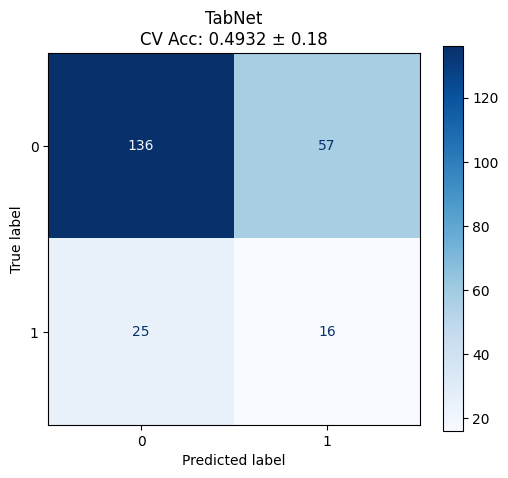

Mô hình Accuracy (Mean ± SD) F1-Score (Mean ± SD)
0  Logistic Regression        0.7835 ± 0.04        0.7829 ± 0.04
1        Decision Tree        0.7982 ± 0.08        0.7925 ± 0.09
2        Random Forest        0.9232 ± 0.08        0.9208 ± 0.09
3                  KNN        0.8884 ± 0.01        0.8873 ± 0.01
4              XGBoost        0.8976 ± 0.11        0.8914 ± 0.12
5             LightGBM        0.8964 ± 0.11        0.8895 ± 0.12
6                  SVM        0.9141 ± 0.03        0.9140 ± 0.03
7               TabNet        0.4932 ± 0.18        0.3785 ± 0.13

In [33]:

print("🔍 Đang tìm K tối ưu cho dữ liệu Cleaned + Resampled...")
best_k_clean = 1
best_acc_clean = 0

X_tr_clean_res = X_resampled_cleaned_outliers_train.values if isinstance(X_resampled_cleaned_outliers_train, pd.DataFrame) else X_resampled_cleaned_outliers_train
y_tr_clean_res = y_resampled_cleaned_outliers_train.values if isinstance(y_resampled_cleaned_outliers_train, pd.Series) else y_resampled_cleaned_outliers_train

X_te_clean = X_cleaned_outliers_test.values if isinstance(X_cleaned_outliers_test, pd.DataFrame) else X_cleaned_outliers_test
y_te_clean = y_cleaned_outliers_test.values if isinstance(y_cleaned_outliers_test, pd.Series) else y_cleaned_outliers_test

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_clean_res, y_tr_clean_res)
    score = knn.score(X_te_clean, y_te_clean)
    if score > best_acc_clean:
        best_acc_clean = score
        best_k_clean = k

print(f"--> K tối ưu là: {best_k_clean} (Acc: {best_acc_clean:.4f})")

models_list_cleaned_resampled = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_clean), # Dùng K mới tìm được
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}


df_final_cleaned_resampled = train_evaluate_full_version(
    models_list_cleaned_resampled, 
    X_resampled_cleaned_outliers_train, 
    y_resampled_cleaned_outliers_train, 
    X_cleaned_outliers_test,            
    y_cleaned_outliers_test             
)

display(df_final_cleaned_resampled)

# 4. TRÍCH XUẤT MODEL RA BIẾN RIÊNG (Để vẽ SHAP hoặc So sánh sau này)
model_clean_lr     = models_list_cleaned_resampled["Logistic Regression"]
model_clean_dt     = models_list_cleaned_resampled["Decision Tree"]
model_clean_rf     = models_list_cleaned_resampled["Random Forest"]
model_clean_knn    = models_list_cleaned_resampled["KNN"]
model_clean_xgb    = models_list_cleaned_resampled["XGBoost"]
model_clean_lgb    = models_list_cleaned_resampled["LightGBM"]
model_clean_svm    = models_list_cleaned_resampled["SVM"]
model_clean_tabnet = models_list_cleaned_resampled["TabNet"]


Đang tính toán dự đoán...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên


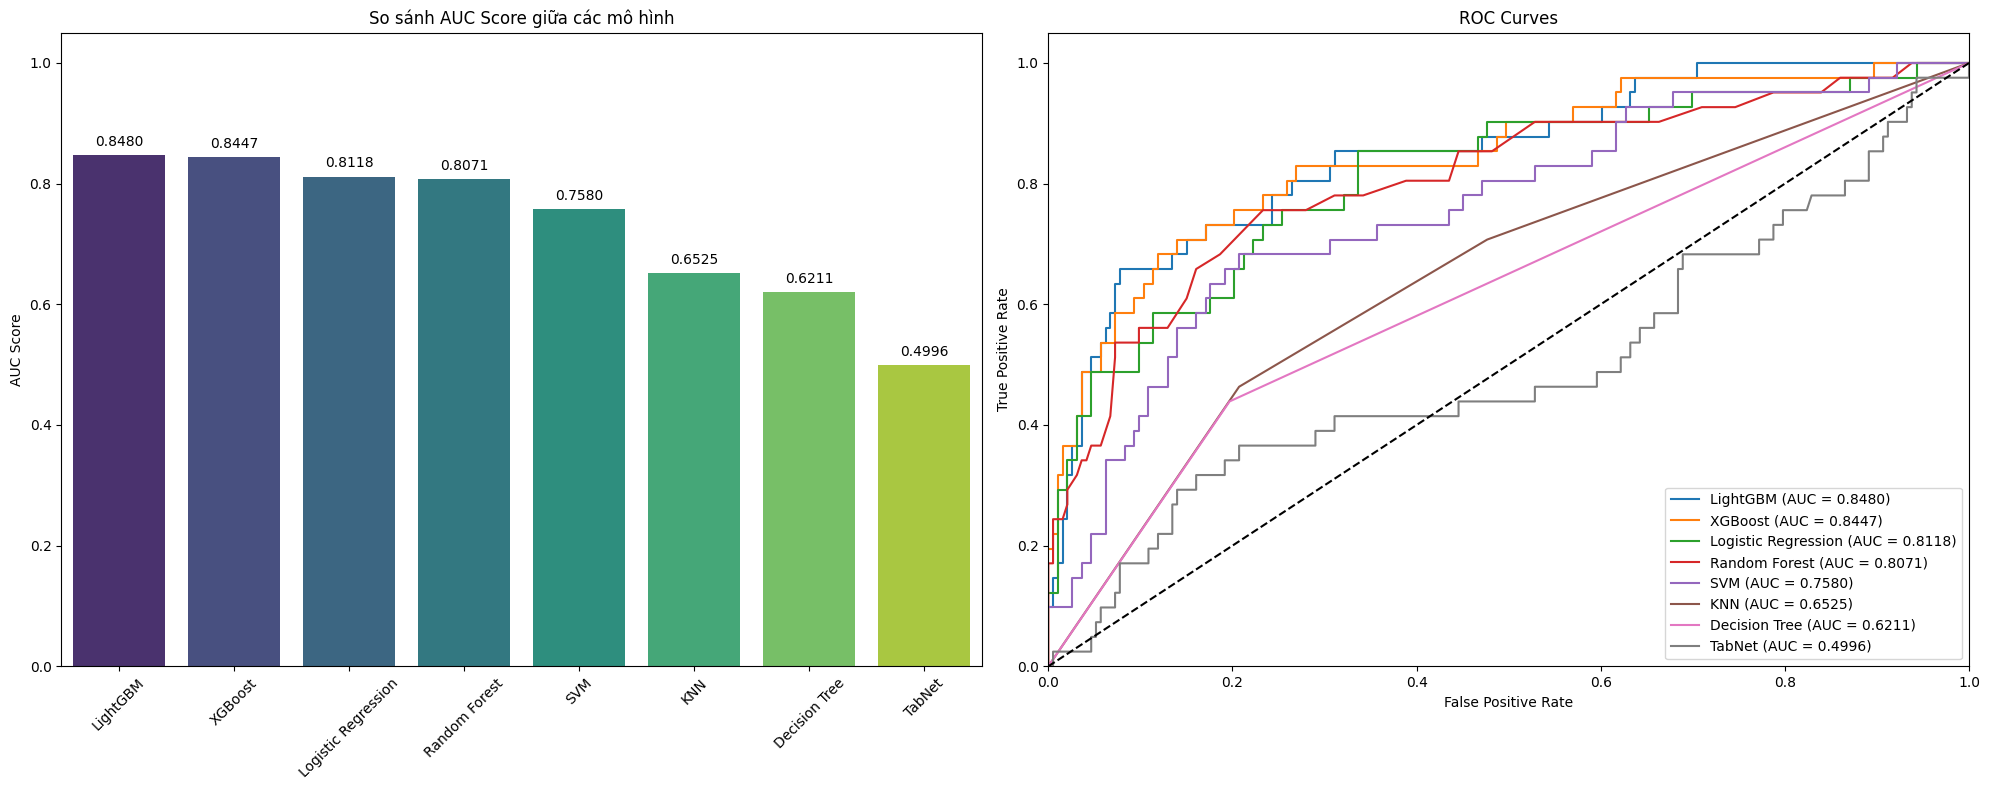

In [34]:
models = {
    "Logistic Regression": model_clean_lr,
    "Decision Tree": model_clean_dt,
    "Random Forest": model_clean_rf,
    "KNN": model_clean_knn,
    "XGBoost": model_clean_xgb,
    "LightGBM": model_clean_lgb,
    "SVM": model_clean_svm,
    "TabNet": model_clean_tabnet
}
SoSanhCacModel(models, X_cleaned_outliers_test, y_cleaned_outliers_test)

**Dùng thử Tensorflow để xây dựng mô hình ANN**

In [35]:
# Dùng tensorflow để xây dựng mô hình ANN (Artificial Neural Network)
model_ann = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_resampled_top_12_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_resampled_top_12_train, y_resampled_top_12_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
y_pred_ann = (model_ann.predict(X_top_12_test) > 0.5).astype("int32")
print("Báo cáo phân loại:")
print(classification_report(y_top_12_test, y_pred_ann))
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_top_12_test, y_pred_ann))
print(f"Độ chính xác của mô hình: {accuracy_score(y_top_12_test, y_pred_ann):.4f}")


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6188 - loss: 0.6332 - val_accuracy: 0.3728 - val_loss: 0.8237
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.5145 - val_accuracy: 0.7543 - val_loss: 0.5383
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7565 - loss: 0.4821 - val_accuracy: 0.7948 - val_loss: 0.4322
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.4620 - val_accuracy: 0.7659 - val_loss: 0.4538
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4343 - val_accuracy: 0.7370 - val_loss: 0.5280
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8058 - loss: 0.4237 - val_accuracy: 0.7572 - val_loss: 0.4707
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4140 - val_accuracy: 0.7977 - val_loss: 0.4192
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8261 - loss: 0.3915 - val_accuracy: 0.7717 - val_loss:

**Huấn luyện mô hình với bộ dữ liệu chỉ lấy ra 12 đặc trưng quan trọng nhất**

--> K tối ưu là: 9 (Acc: 0.8503)

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       370
           1       0.64      0.23      0.33        71

    accuracy                           0.85       441
   macro avg       0.75      0.60      0.63       441
weighted avg       0.83      0.85      0.82       441

Confusion Matrix cho Logistic Regression...


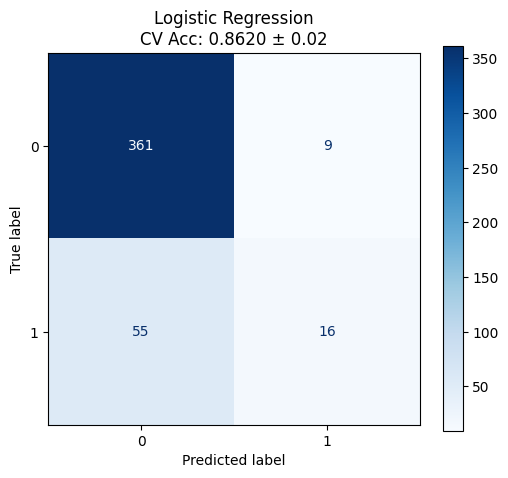


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       370
           1       0.38      0.35      0.36        71

    accuracy                           0.80       441
   macro avg       0.63      0.62      0.62       441
weighted avg       0.80      0.80      0.80       441

Confusion Matrix cho Decision Tree...


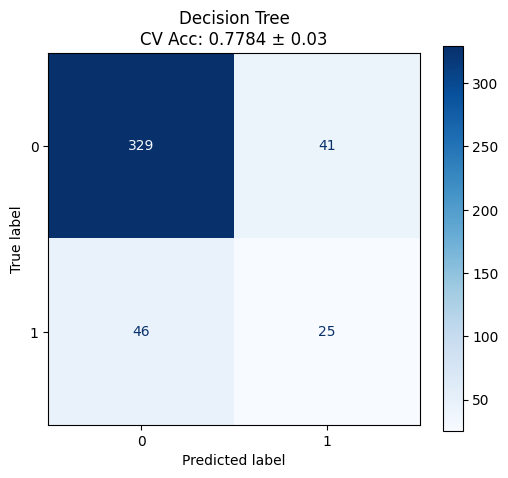


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       370
           1       0.54      0.20      0.29        71

    accuracy                           0.84       441
   macro avg       0.70      0.58      0.60       441
weighted avg       0.81      0.84      0.81       441

Confusion Matrix cho Random Forest...


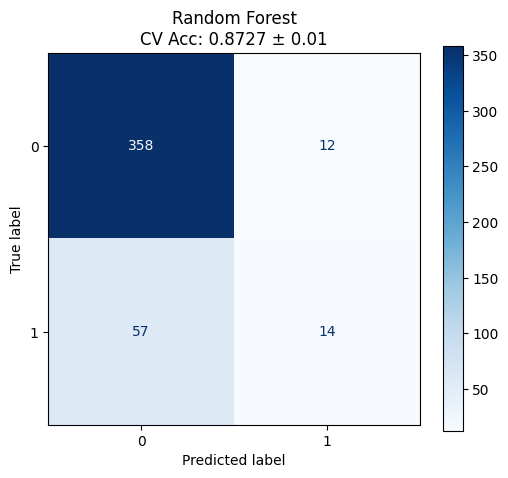


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       370
           1       0.69      0.13      0.21        71

    accuracy                           0.85       441
   macro avg       0.77      0.56      0.57       441
weighted avg       0.83      0.85      0.80       441

Confusion Matrix cho KNN...


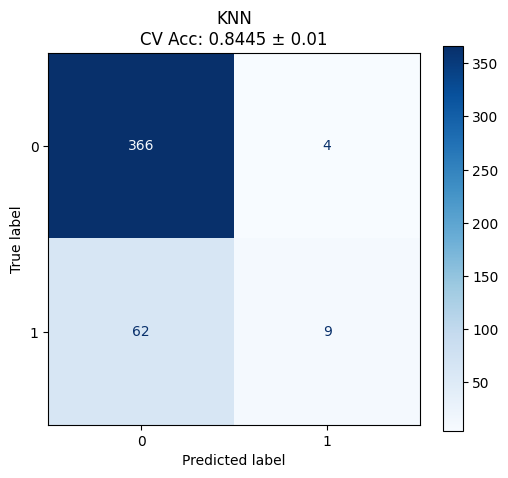

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:05] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       370
           1       0.56      0.31      0.40        71

    accuracy                           0.85       441
   macro avg       0.72      0.63      0.66       441
weighted avg       0.83      0.85      0.83       441

Confusion Matrix cho XGBoost...


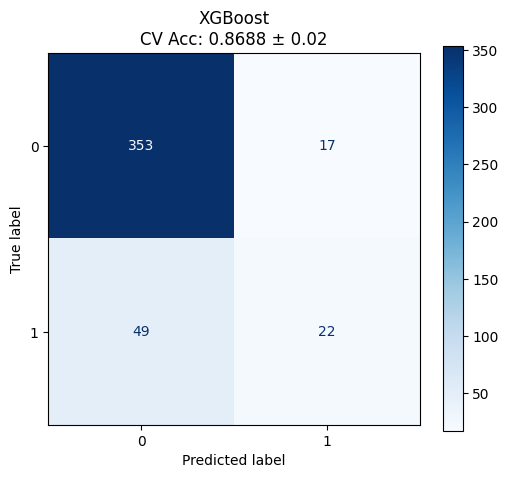


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       370
           1       0.51      0.27      0.35        71

    accuracy                           0.84       441
   macro avg       0.69      0.61      0.63       441
weighted avg       0.81      0.84      0.82       441

Confusion Matrix cho LightGBM...


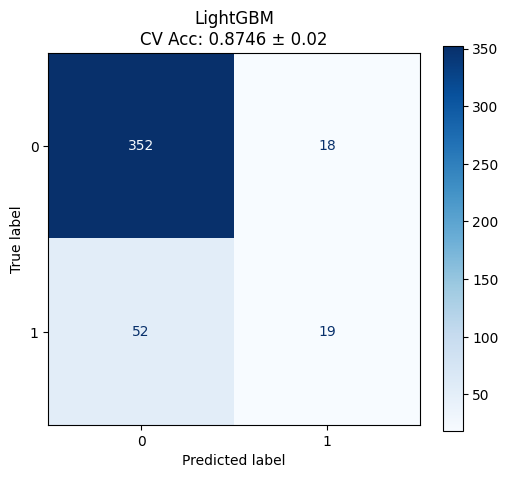


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       370
           1       0.91      0.14      0.24        71

    accuracy                           0.86       441
   macro avg       0.88      0.57      0.58       441
weighted avg       0.87      0.86      0.81       441

Confusion Matrix cho SVM...


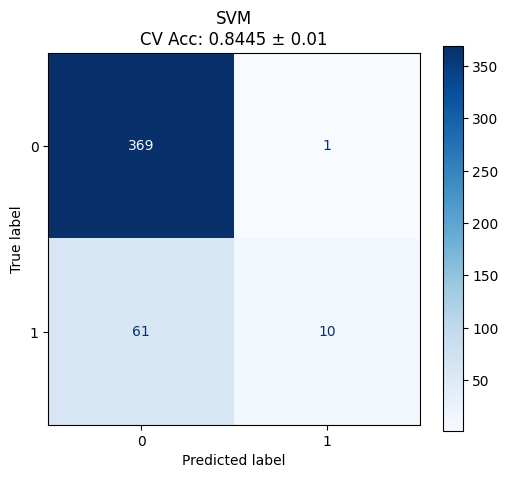

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       370
           1       0.56      0.14      0.22        71

    accuracy                           0.84       441
   macro avg       0.71      0.56      0.57       441
weighted avg       0.81      0.84      0.80       441

Confusion Matrix cho TabNet...


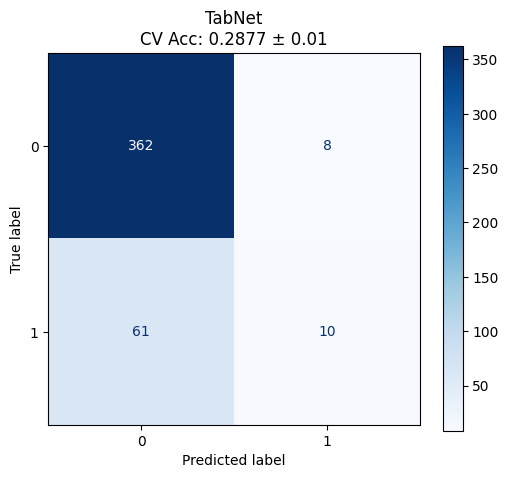

Mô hình Accuracy (Mean ± SD) F1-Score (Mean ± SD)
0  Logistic Regression        0.8620 ± 0.02        0.6425 ± 0.05
1        Decision Tree        0.7784 ± 0.03        0.6066 ± 0.03
2        Random Forest        0.8727 ± 0.01        0.6629 ± 0.05
3                  KNN        0.8445 ± 0.01        0.5362 ± 0.03
4              XGBoost        0.8688 ± 0.02        0.7054 ± 0.05
5             LightGBM        0.8746 ± 0.02        0.7185 ± 0.04
6                  SVM        0.8445 ± 0.01        0.5443 ± 0.03
7               TabNet        0.2877 ± 0.01        0.2855 ± 0.01

In [36]:
best_k_top12 = 1
best_acc_top12 = 0

X_tr_top12 = X_top_12_train.values if isinstance(X_top_12_train, pd.DataFrame) else X_top_12_train
y_tr_top12 = y_top_12_train.values if isinstance(y_top_12_train, pd.Series) else y_top_12_train
X_te_top12 = X_top_12_test.values if isinstance(X_top_12_test, pd.DataFrame) else X_top_12_test
y_te_top12 = y_top_12_test.values if isinstance(y_top_12_test, pd.Series) else y_top_12_test

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_top12, y_tr_top12)
    score = knn.score(X_te_top12, y_te_top12)
    if score > best_acc_top12:
        best_acc_top12 = score
        best_k_top12 = k

print(f"--> K tối ưu là: {best_k_top12} (Acc: {best_acc_top12:.4f})")

models_list_top12 = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_top12), # K mới
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}

df_final_top12 = train_evaluate_full_version(
    models_list_top12, 
    X_top_12_train, 
    y_top_12_train, 
    X_top_12_test, 
    y_top_12_test
)

display(df_final_top12)

model_top12_lr     = models_list_top12["Logistic Regression"]
model_top12_dt     = models_list_top12["Decision Tree"]
model_top12_rf     = models_list_top12["Random Forest"]
model_top12_knn    = models_list_top12["KNN"]
model_top12_xgb    = models_list_top12["XGBoost"]
model_top12_lgb    = models_list_top12["LightGBM"]
model_top12_svm    = models_list_top12["SVM"]
model_top12_tabnet = models_list_top12["TabNet"]


Đang tính toán dự đoán...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên


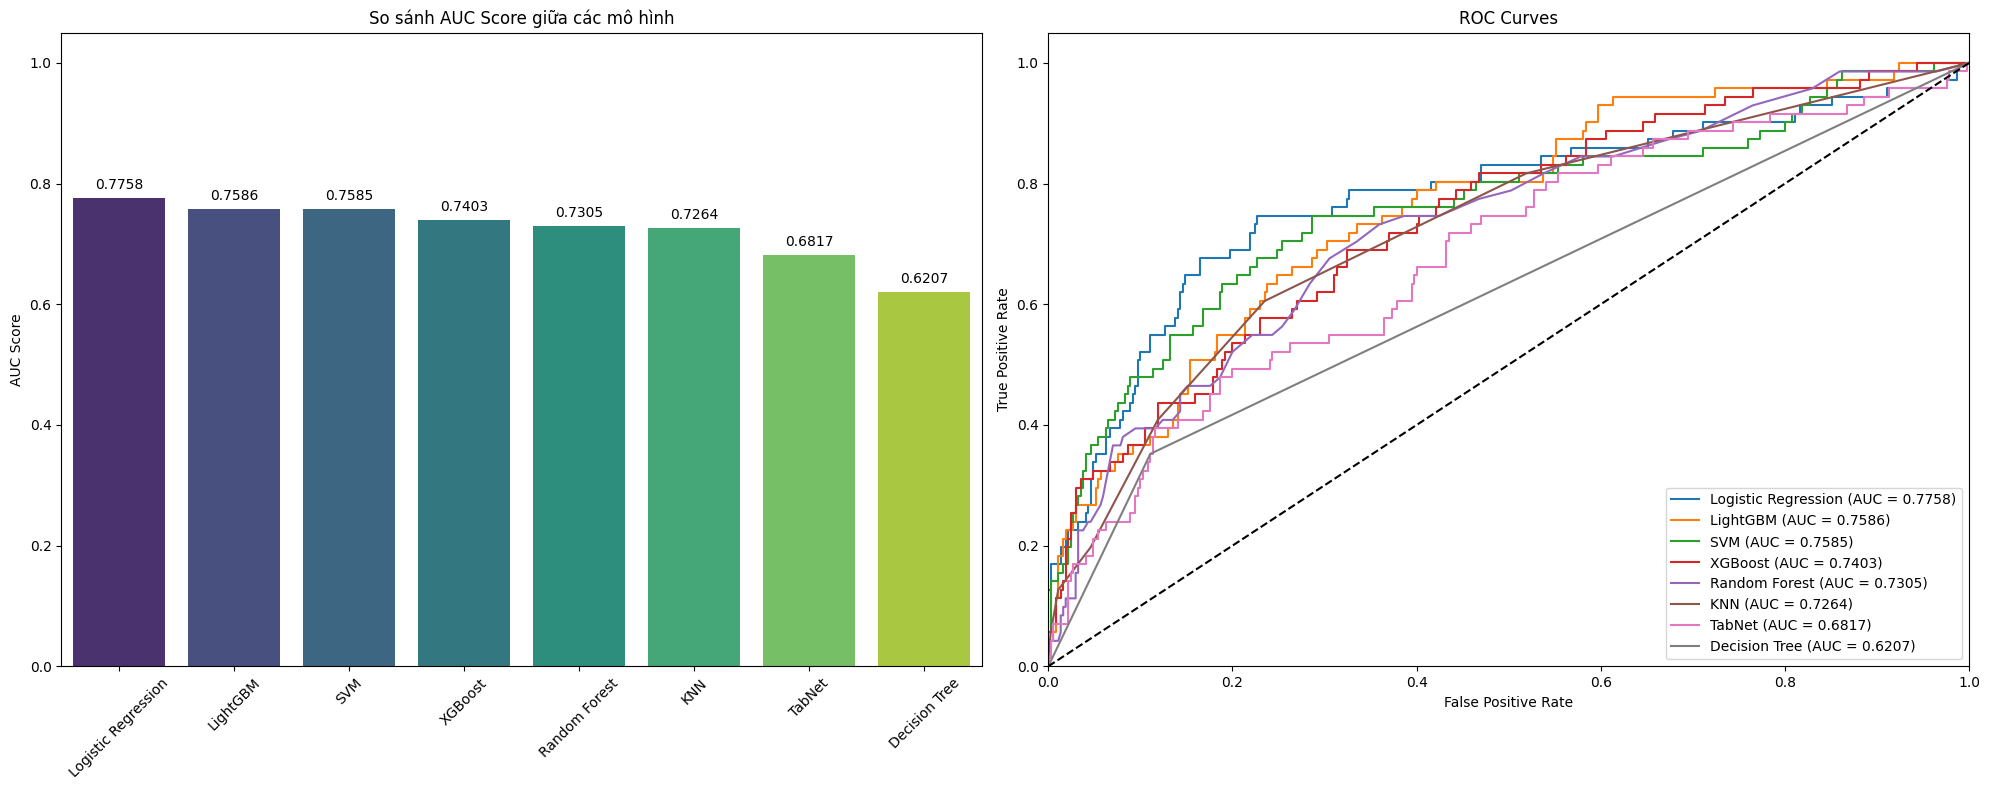

In [37]:
models = {
    "Logistic Regression": model_top12_lr,
    "Decision Tree": model_top12_dt,
    "Random Forest": model_top12_rf,
    "KNN": model_top12_knn,
    "XGBoost": model_top12_xgb,
    "LightGBM": model_top12_lgb,
    "SVM": model_top12_svm,
    "TabNet": model_top12_tabnet
}
SoSanhCacModel(models, X_top_12_test, y_top_12_test)

**Huấn luyện các mô hình với dữ liệu chỉ lấy 12 đặc trưng quan trọng nhất và có resampled bằng SMOTE**


--> K tối ưu là: 2 (Acc: 0.7914)

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       370
           1       0.34      0.75      0.47        71

    accuracy                           0.73       441
   macro avg       0.64      0.74      0.64       441
weighted avg       0.84      0.73      0.76       441

Confusion Matrix cho Logistic Regression...


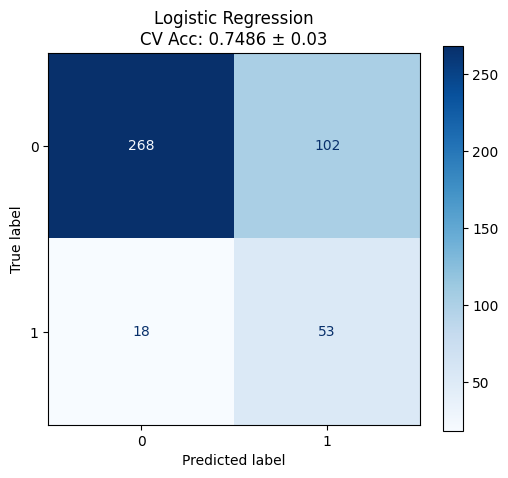


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       370
           1       0.25      0.30      0.27        71

    accuracy                           0.74       441
   macro avg       0.55      0.56      0.56       441
weighted avg       0.76      0.74      0.75       441

Confusion Matrix cho Decision Tree...


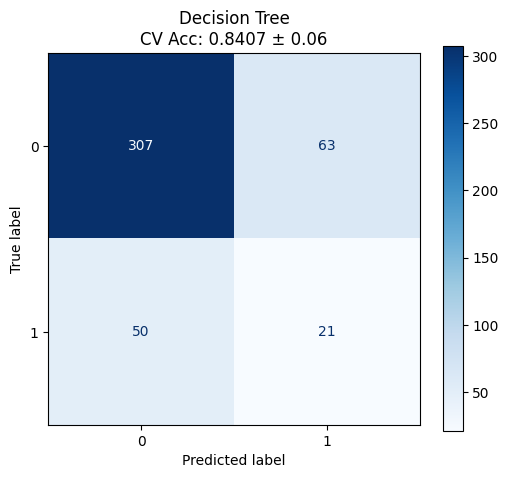


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       370
           1       0.49      0.31      0.38        71

    accuracy                           0.84       441
   macro avg       0.68      0.62      0.64       441
weighted avg       0.81      0.84      0.82       441

Confusion Matrix cho Random Forest...


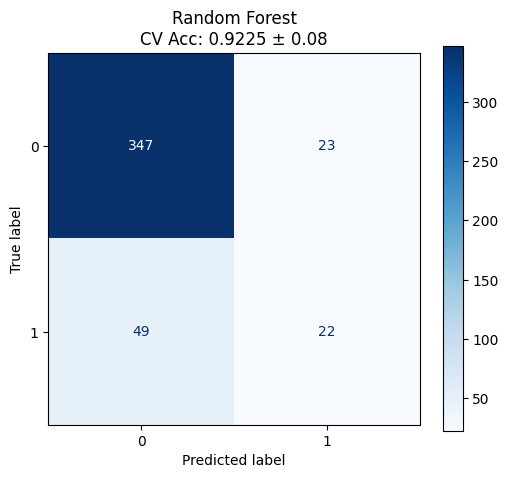


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       370
           1       0.34      0.32      0.33        71

    accuracy                           0.79       441
   macro avg       0.61      0.60      0.60       441
weighted avg       0.79      0.79      0.79       441

Confusion Matrix cho KNN...


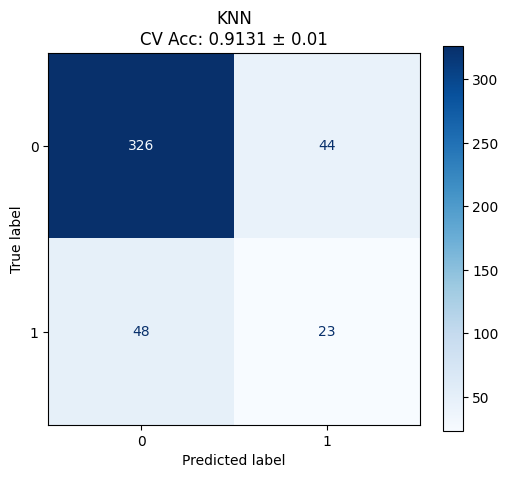

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:29:14] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       370
           1       0.49      0.32      0.39        71

    accuracy                           0.84       441
   macro avg       0.68      0.63      0.65       441
weighted avg       0.82      0.84      0.82       441

Confusion Matrix cho XGBoost...


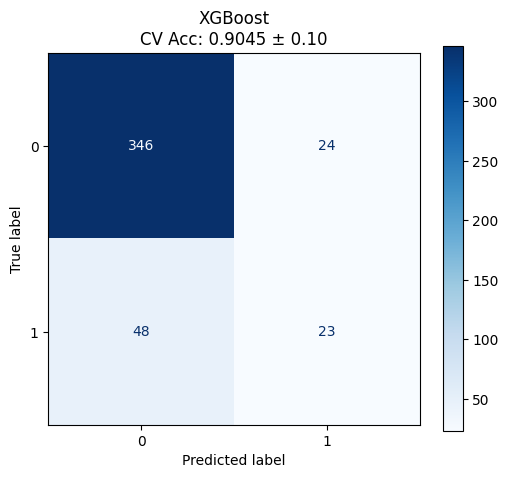


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       370
           1       0.52      0.31      0.39        71

    accuracy                           0.84       441
   macro avg       0.70      0.63      0.65       441
weighted avg       0.82      0.84      0.83       441

Confusion Matrix cho LightGBM...


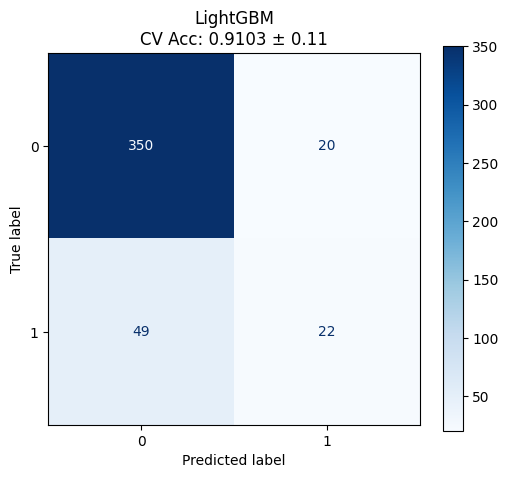


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       370
           1       0.38      0.55      0.45        71

    accuracy                           0.78       441
   macro avg       0.64      0.69      0.66       441
weighted avg       0.82      0.78      0.80       441

Confusion Matrix cho SVM...


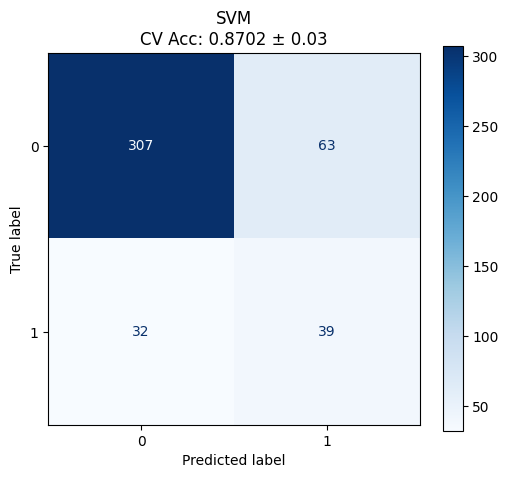

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       370
           1       0.26      0.58      0.36        71

    accuracy                           0.67       441
   macro avg       0.58      0.63      0.57       441
weighted avg       0.79      0.67      0.71       441

Confusion Matrix cho TabNet...


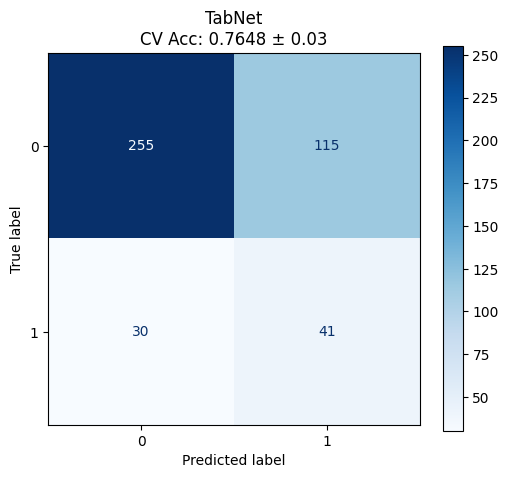

Mô hình Accuracy (Mean ± SD) F1-Score (Mean ± SD)
0  Logistic Regression        0.7486 ± 0.03        0.7484 ± 0.03
1        Decision Tree        0.8407 ± 0.06        0.8391 ± 0.06
2        Random Forest        0.9225 ± 0.08        0.9210 ± 0.08
3                  KNN        0.9131 ± 0.01        0.9126 ± 0.01
4              XGBoost        0.9045 ± 0.10        0.8998 ± 0.11
5             LightGBM        0.9103 ± 0.11        0.9049 ± 0.12
6                  SVM        0.8702 ± 0.03        0.8701 ± 0.03
7               TabNet        0.7648 ± 0.03        0.5822 ± 0.11

In [38]:
best_k_top12_res = 1
best_acc_top12_res = 0

X_tr_top12_res = X_resampled_top_12_train.values if isinstance(X_resampled_top_12_train, pd.DataFrame) else X_resampled_top_12_train
y_tr_top12_res = y_resampled_top_12_train.values if isinstance(y_resampled_top_12_train, pd.Series) else y_resampled_top_12_train
X_te_top12 = X_top_12_test.values if isinstance(X_top_12_test, pd.DataFrame) else X_top_12_test
y_te_top12 = y_top_12_test.values if isinstance(y_top_12_test, pd.Series) else y_top_12_test

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_top12_res, y_tr_top12_res)
    score = knn.score(X_te_top12, y_te_top12)
    if score > best_acc_top12_res:
        best_acc_top12_res = score
        best_k_top12_res = k

print(f"--> K tối ưu là: {best_k_top12_res} (Acc: {best_acc_top12_res:.4f})")

models_list_top12_res = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_top12_res), # Dùng K mới
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}

df_final_top12_res = train_evaluate_full_version(
    models_list_top12_res, 
    X_resampled_top_12_train,
    y_resampled_top_12_train, 
    X_top_12_test,            
    y_top_12_test             
)

display(df_final_top12_res)

model_top12_res_lr     = models_list_top12_res["Logistic Regression"]
model_top12_res_dt     = models_list_top12_res["Decision Tree"]
model_top12_res_rf     = models_list_top12_res["Random Forest"]
model_top12_res_knn    = models_list_top12_res["KNN"]
model_top12_res_xgb    = models_list_top12_res["XGBoost"]
model_top12_res_lgb    = models_list_top12_res["LightGBM"]
model_top12_res_svm    = models_list_top12_res["SVM"]
model_top12_res_tabnet = models_list_top12_res["TabNet"]

Đang tính toán dự đoán...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên


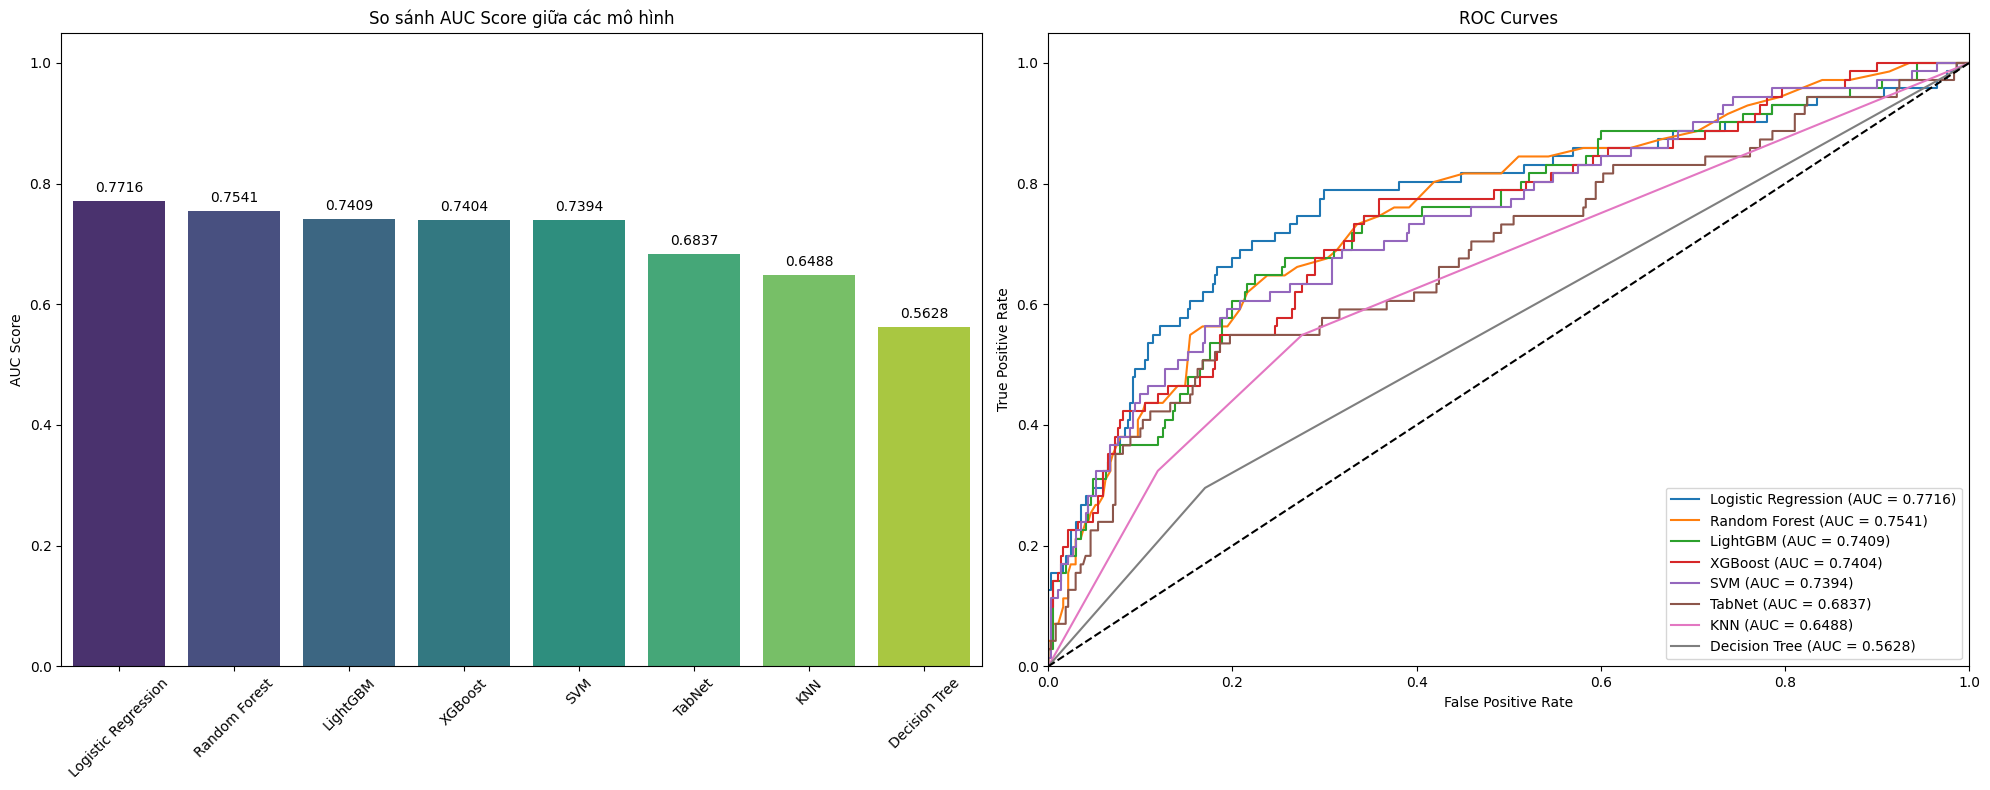

In [39]:
models = {
    "Logistic Regression": model_top12_res_lr,
    "Decision Tree": model_top12_res_dt,
    "Random Forest": model_top12_res_rf,
    "KNN": model_top12_res_knn,
    "XGBoost": model_top12_res_xgb,
    "LightGBM": model_top12_res_lgb,
    "SVM": model_top12_res_svm,
    "TabNet": model_top12_res_tabnet
}
SoSanhCacModel(models, X_top_12_test, y_top_12_test)

**Huấn luyện mô hình với tập dữ liệu qua RFE và SMOTE**

--> K tối ưu là: 2 (Acc: 0.7574)

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.75      0.84       370
           1       0.37      0.76      0.50        71

    accuracy                           0.75       441
   macro avg       0.66      0.76      0.67       441
weighted avg       0.85      0.75      0.78       441

Confusion Matrix cho Logistic Regression...


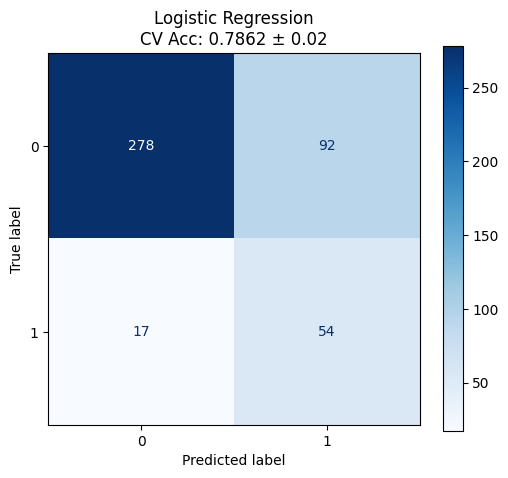


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       370
           1       0.30      0.37      0.33        71

    accuracy                           0.76       441
   macro avg       0.59      0.60      0.59       441
weighted avg       0.78      0.76      0.77       441

Confusion Matrix cho Decision Tree...


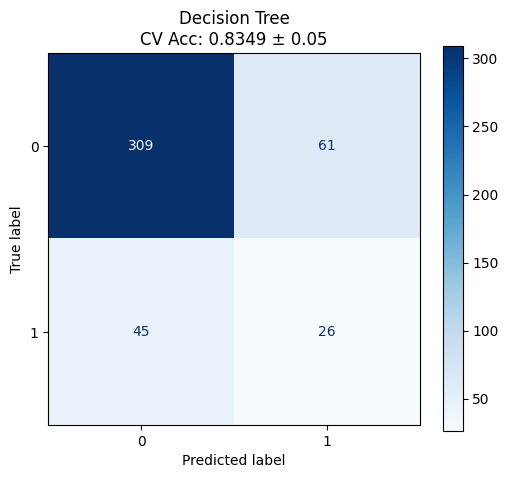


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       370
           1       0.45      0.27      0.34        71

    accuracy                           0.83       441
   macro avg       0.66      0.60      0.62       441
weighted avg       0.80      0.83      0.81       441

Confusion Matrix cho Random Forest...


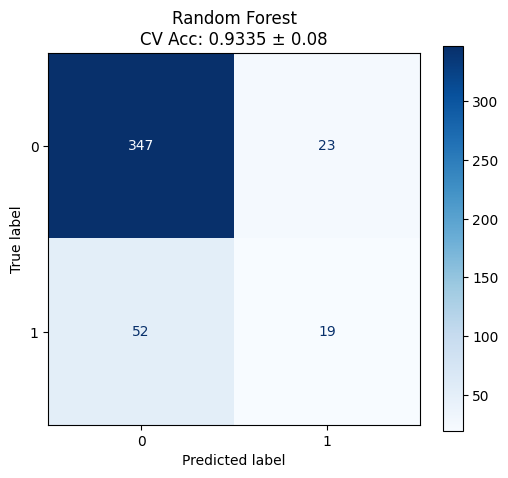


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       370
           1       0.25      0.25      0.25        71

    accuracy                           0.76       441
   macro avg       0.55      0.55      0.55       441
weighted avg       0.76      0.76      0.76       441

Confusion Matrix cho KNN...


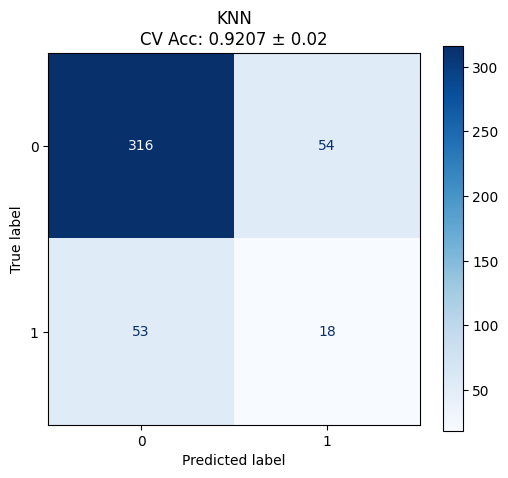

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:30:00] WARNING: C:\actio


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       370
           1       0.55      0.34      0.42        71

    accuracy                           0.85       441
   macro avg       0.71      0.64      0.67       441
weighted avg       0.83      0.85      0.83       441

Confusion Matrix cho XGBoost...


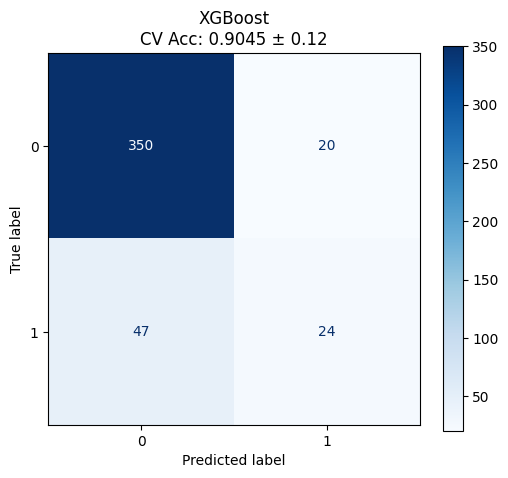


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       370
           1       0.57      0.32      0.41        71

    accuracy                           0.85       441
   macro avg       0.73      0.64      0.67       441
weighted avg       0.83      0.85      0.83       441

Confusion Matrix cho LightGBM...


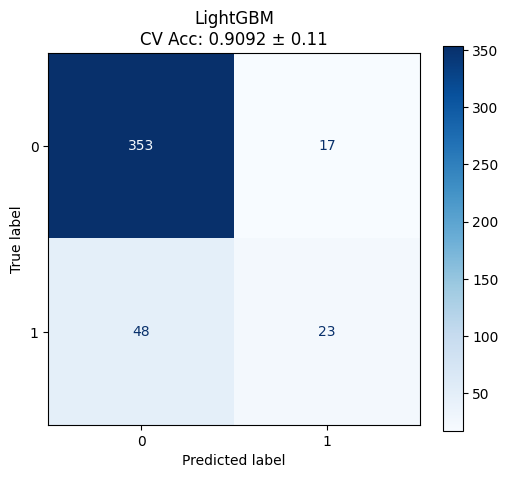


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       370
           1       0.50      0.56      0.53        71

    accuracy                           0.84       441
   macro avg       0.71      0.73      0.72       441
weighted avg       0.85      0.84      0.84       441

Confusion Matrix cho SVM...


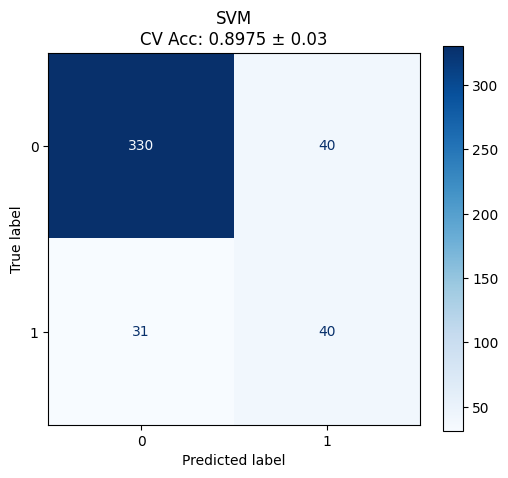

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: U


Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       370
           1       0.28      0.66      0.39        71

    accuracy                           0.67       441
   macro avg       0.59      0.67      0.58       441
weighted avg       0.81      0.67      0.71       441

Confusion Matrix cho TabNet...


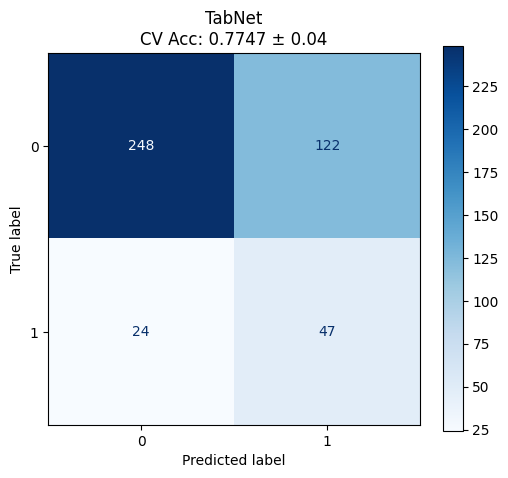

Mô hình Accuracy (Mean ± SD) F1-Score (Mean ± SD)
0  Logistic Regression        0.7862 ± 0.02        0.7860 ± 0.02
1        Decision Tree        0.8349 ± 0.05        0.8334 ± 0.05
2        Random Forest        0.9335 ± 0.08        0.9318 ± 0.08
3                  KNN        0.9207 ± 0.02        0.9202 ± 0.02
4              XGBoost        0.9045 ± 0.12        0.8970 ± 0.13
5             LightGBM        0.9092 ± 0.11        0.9027 ± 0.12
6                  SVM        0.8975 ± 0.03        0.8974 ± 0.03
7               TabNet        0.7747 ± 0.04        0.5881 ± 0.12

In [40]:
best_k_rfecv = 1
best_acc_rfecv = 0

X_tr_rfecv = X_resampled_rfecv_train.values if isinstance(X_resampled_rfecv_train, pd.DataFrame) else X_resampled_rfecv_train
y_tr_rfecv = y_resampled_rfecv_train.values if isinstance(y_resampled_rfecv_train, pd.Series) else y_resampled_rfecv_train
X_te_rfecv = X_test_rfecv.values if isinstance(X_test_rfecv, pd.DataFrame) else X_test_rfecv
y_te_real = y_test.values if isinstance(y_test, pd.Series) else y_test

for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_rfecv, y_tr_rfecv)
    score = knn.score(X_te_rfecv, y_te_real)
    if score > best_acc_rfecv:
        best_acc_rfecv = score
        best_k_rfecv = k

print(f"--> K tối ưu là: {best_k_rfecv} (Acc: {best_acc_rfecv:.4f})")

models_list_rfecv = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=best_k_rfecv), # Dùng K mới
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "SVM": SVC(random_state=42),
    "TabNet": TabNetClassifier(seed=42, verbose=0, optimizer_params=dict(lr=0.02))
}


df_final_rfecv = train_evaluate_full_version(
    models_list_rfecv, 
    X_resampled_rfecv_train, 
    y_resampled_rfecv_train, 
    X_test_rfecv,            
    y_test                   
)

display(df_final_rfecv)

model_rfecv_lr     = models_list_rfecv["Logistic Regression"]
model_rfecv_dt     = models_list_rfecv["Decision Tree"]
model_rfecv_rf     = models_list_rfecv["Random Forest"]
model_rfecv_knn    = models_list_rfecv["KNN"]
model_rfecv_xgb    = models_list_rfecv["XGBoost"]
model_rfecv_lgb    = models_list_rfecv["LightGBM"]
model_rfecv_svm    = models_list_rfecv["SVM"]
model_rfecv_tabnet = models_list_rfecv["TabNet"]

Đang tính toán dự đoán...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=auc_values, palette='viridis', ax=axes[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\309670019.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  axes[1].plot([0, 1], [0, 1], 'k--', linestyle='--') # Đường chéo ngẫu nhiên


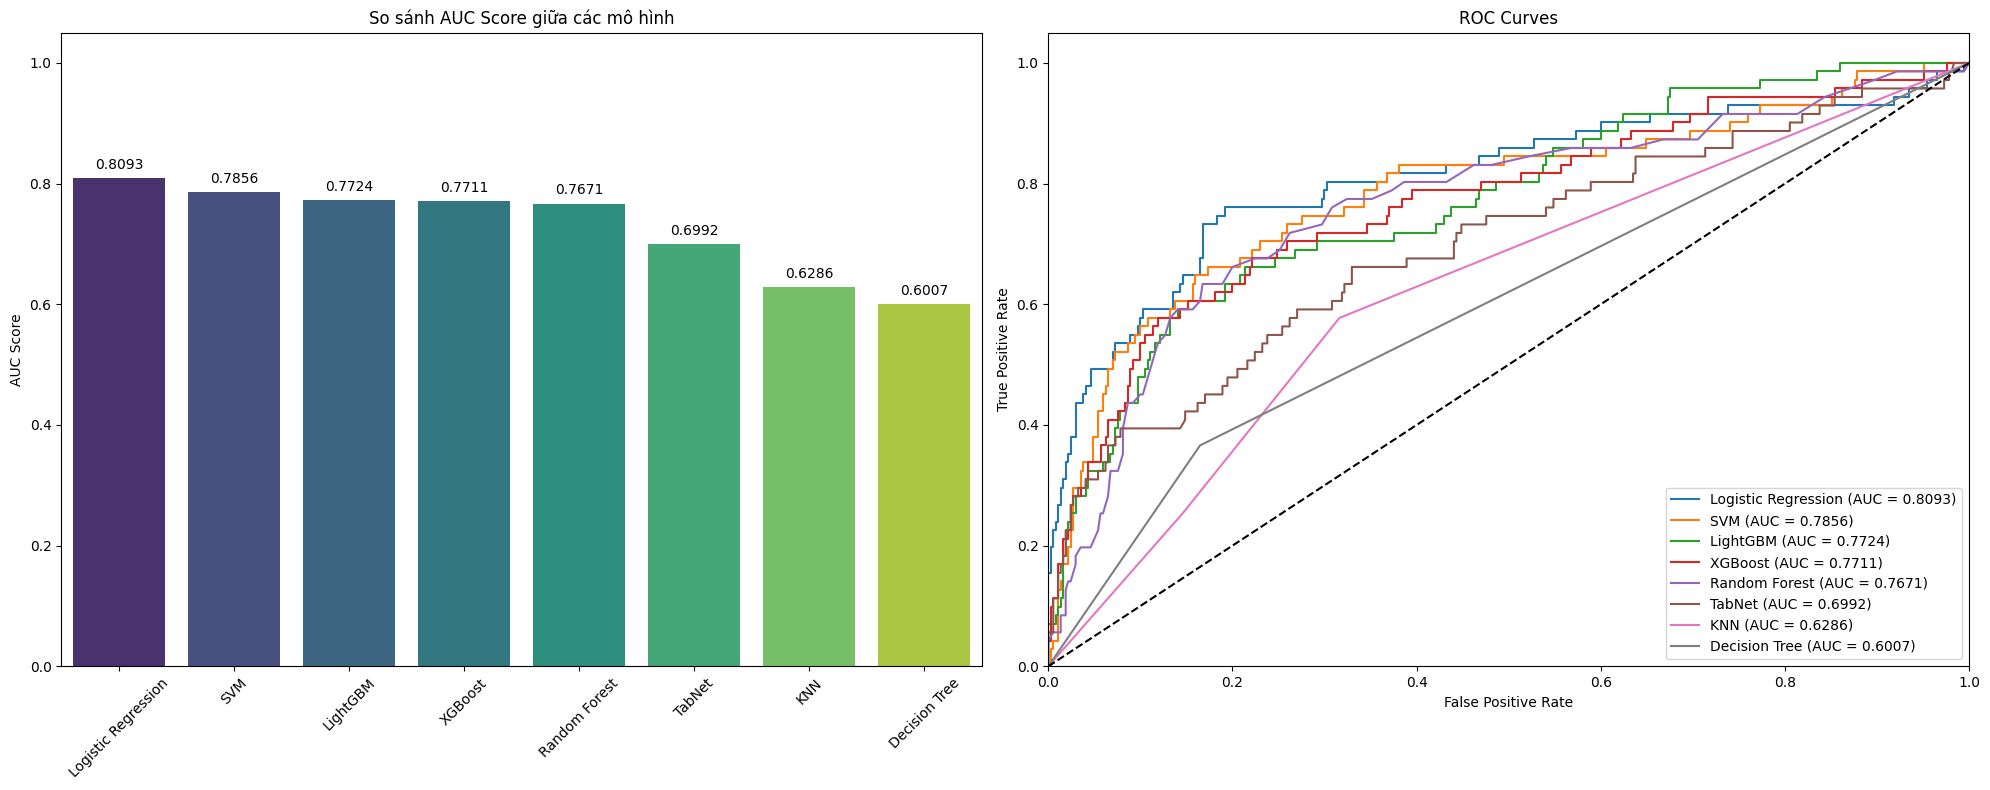

In [41]:
models = {
    "Logistic Regression": model_rfecv_lr,
    "Decision Tree": model_rfecv_dt,
    "Random Forest": model_rfecv_rf,
    "KNN": model_rfecv_knn,
    "XGBoost": model_rfecv_xgb,
    "LightGBM": model_rfecv_lgb,
    "SVM": model_rfecv_svm,
    "TabNet": model_rfecv_tabnet
}
SoSanhCacModel(models, X_test_rfecv, y_test)

Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.7903
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best accuracy for Random Forest: 0.9387


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:31:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300}
Best accuracy for XGBoost: 0.9213


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for LightGBM: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
Best accuracy for LightGBM: 0.9202
Báo cáo phân loại cho Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       370
           1       0.39      0.73      0.51        71

    accuracy                           0.78       441
   macro avg       0.67      0.76      0.68       441
weighted avg       0.85      0.78      0.80       441



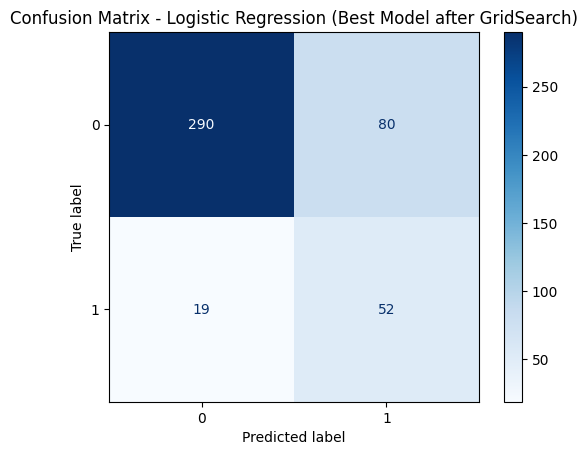

Độ chính xác của mô hình Logistic Regression: 0.7755
Báo cáo phân loại cho Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.59      0.24      0.34        71

    accuracy                           0.85       441
   macro avg       0.73      0.60      0.63       441
weighted avg       0.82      0.85      0.82       441



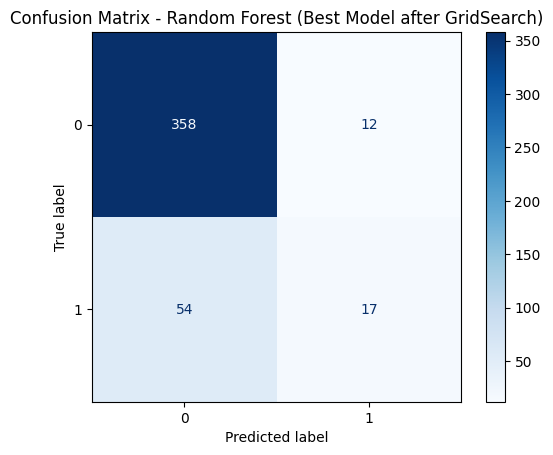

Độ chính xác của mô hình Random Forest: 0.8503
Báo cáo phân loại cho XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       370
           1       0.49      0.35      0.41        71

    accuracy                           0.84       441
   macro avg       0.69      0.64      0.66       441
weighted avg       0.82      0.84      0.83       441



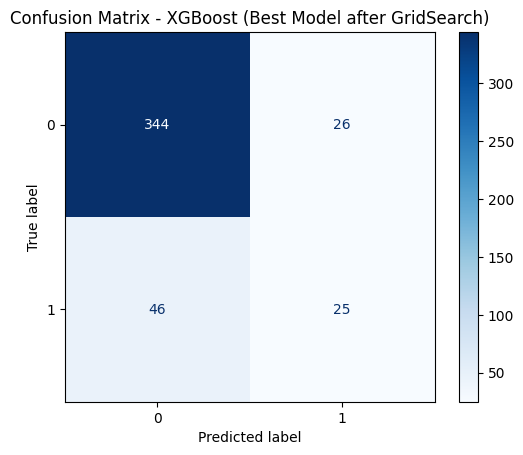

Độ chính xác của mô hình XGBoost: 0.8367
Báo cáo phân loại cho LightGBM:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       370
           1       0.50      0.38      0.43        71

    accuracy                           0.84       441
   macro avg       0.69      0.65      0.67       441
weighted avg       0.82      0.84      0.83       441



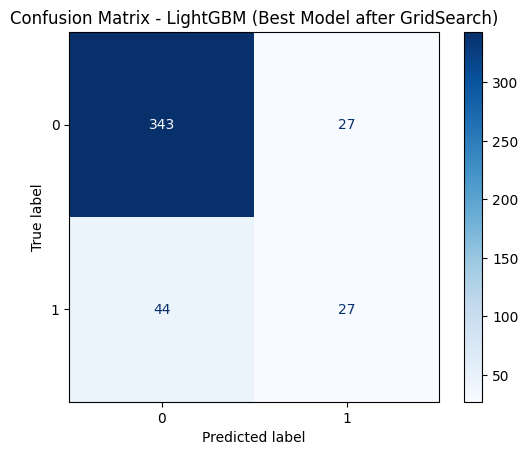

Độ chính xác của mô hình LightGBM: 0.8390


In [42]:
# GridSearch cho Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Logistic Regression: {grid_lr.best_params_}")
print(f"Best accuracy for Logistic Regression: {grid_lr.best_score_:.4f}")
best_lr = grid_lr.best_estimator_

# GridSearch cho Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")
print(f"Best accuracy for Random Forest: {grid_rf.best_score_:.4f}")
best_rf = grid_rf.best_estimator_


# GridSearch cho XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42), param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for XGBoost: {grid_xgb.best_params_}")
print(f"Best accuracy for XGBoost: {grid_xgb.best_score_:.4f}")
best_xgb = grid_xgb.best_estimator_

# GridSearch cho LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgb.fit(X_resampled_train, y_resampled_train)
print(f"Best parameters for LightGBM: {grid_lgb.best_params_}")
print(f"Best accuracy for LightGBM: {grid_lgb.best_score_:.4f}")
best_lgb = grid_lgb.best_estimator_

# Test các mô hình tốt nhất sau GridSearch trên tập test
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'LightGBM': best_lgb
}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"Báo cáo phân loại cho {model_name}:")
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=[0,1])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {model_name} (Best Model after GridSearch)')
    plt.show()
    print(f"Độ chính xác của mô hình {model_name}: {accuracy_score(y_test, y_pred):.4f}")



c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:31:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


📊 Đang tính toán AUC và vẽ biểu đồ...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\953096401.py:95: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3284\953096401.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Mô hình", y="AUC Score", palette="viridis")


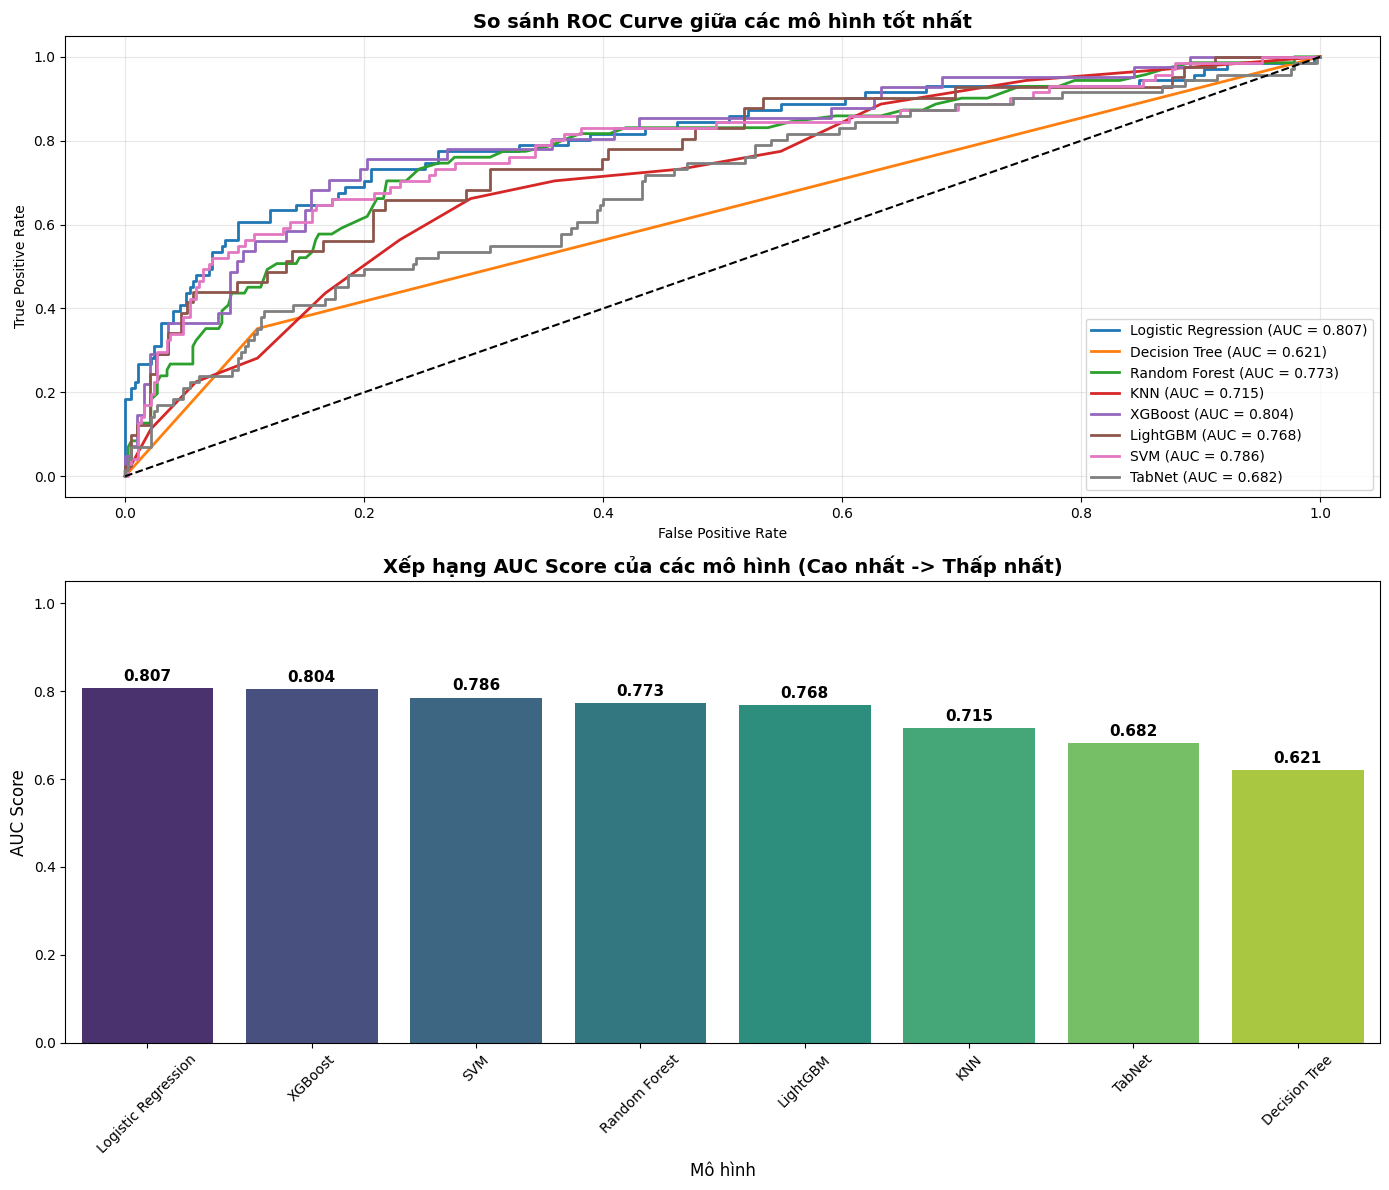

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

final_models = []
# 1. Logistic Regression (Dữ liệu Gốc)
lr = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, C=100)
lr.fit(X_train, y_train)
final_models.append({"name": "Logistic Regression", "model": lr, "X_val": X_test, "y_val": y_test})

# 2. Decision Tree (12 Đặc trưng)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_top_12_train, y_top_12_train)
final_models.append({"name": "Decision Tree", "model": dt, "X_val": X_top_12_test, "y_val": y_top_12_test})

# 3. Random Forest (SMOTE)
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, random_state=42)
rf.fit(X_resampled_train, y_resampled_train)
final_models.append({"name": "Random Forest", "model": rf, "X_val": X_test, "y_val": y_test})

# 4. KNN (Top 12 + SMOTE)
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_resampled_top_12_train, y_resampled_top_12_train)
final_models.append({"name": "KNN", "model": knn, "X_val": X_top_12_test, "y_val": y_top_12_test})

# 5. XGBoost (SMOTE + IQR) - Test trên tập đã loại ngoại lai tương ứng
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, 
                    learning_rate=0.01, max_depth=9, n_estimators=300)
xgb.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
final_models.append({"name": "XGBoost", "model": xgb, "X_val": X_cleaned_outliers_test, "y_val": y_cleaned_outliers_test})

# 6. LightGBM (SMOTE + IQR)
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1,
                          learning_rate=0.01, max_depth=10, n_estimators=200)
lgbm.fit(X_resampled_cleaned_outliers_train, y_resampled_cleaned_outliers_train)
final_models.append({"name": "LightGBM", "model": lgbm, "X_val": X_cleaned_outliers_test, "y_val": y_cleaned_outliers_test})

# 7. SVM (RFE + SMOTE)
svm = SVC(probability=True, random_state=42)
svm.fit(X_resampled_rfecv_train, y_resampled_rfecv_train)
final_models.append({"name": "SVM", "model": svm, "X_val": X_test_rfecv, "y_val": y_test})

# 8. TabNet (Top 12)
# Chuyển đổi sang numpy cho TabNet
X_tab_train = X_top_12_train if isinstance(X_top_12_train, np.ndarray) else X_top_12_train.values
y_tab_train = y_top_12_train if isinstance(y_top_12_train, np.ndarray) else y_top_12_train.values
X_tab_test = X_top_12_test if isinstance(X_top_12_test, np.ndarray) else X_top_12_test.values
y_tab_test = y_top_12_test if isinstance(y_top_12_test, np.ndarray) else y_top_12_test.values

tabnet = TabNetClassifier(seed=42, verbose=0)
tabnet.fit(X_tab_train, y_tab_train, max_epochs=50, batch_size=1024)
final_models.append({"name": "TabNet", "model": tabnet, "X_val": X_tab_test, "y_val": y_tab_test})


# --- BƯỚC 2: TÍNH TOÁN VÀ LƯU KẾT QUẢ ---
results_data = []

print("📊 Đang tính toán AUC và vẽ biểu đồ...")

plt.figure(figsize=(14, 12))

# Subplot 1: ROC Curves
plt.subplot(2, 1, 1)

for item in final_models:
    name = item['name']
    model = item['model']
    X_val = item['X_val']
    y_val = item['y_val']
    
    try:
        # Lấy xác suất
        if "TabNet" in name:
            y_probs = model.predict_proba(X_val)[:, 1]
        elif hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_val)[:, 1]
        else:
            y_probs = model.decision_function(X_val)
            
        # Tính metrics
        fpr, tpr, _ = roc_curve(y_val, y_probs)
        auc = roc_auc_score(y_val, y_probs)
        
        # Lưu lại để vẽ bar chart
        results_data.append({"Mô hình": name, "AUC Score": auc})
        
        # Vẽ đường ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
        
    except Exception as e:
        print(f"Lỗi {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('So sánh ROC Curve giữa các mô hình tốt nhất', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)

df_results = pd.DataFrame(results_data).sort_values(by="AUC Score", ascending=False)

sns.barplot(data=df_results, x="Mô hình", y="AUC Score", palette="viridis")
plt.ylim(0, 1.05)
plt.title('Xếp hạng AUC Score của các mô hình (Cao nhất -> Thấp nhất)', fontsize=14, fontweight='bold')
plt.xlabel('Mô hình', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.xticks(rotation=45)

for index, row in df_results.iterrows():
    pass 

for i, v in enumerate(df_results["AUC Score"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()